In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import math
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, spearmanr

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_52585/4074614716.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (

In [3]:
disp_data = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")

disp_data = disp_data[(disp_data['Reason']=='Drought related')]# | (disp_data['Reason']=='Flood')]
inv_distance = 1/distance
df_d['admin1'] = df_d['admin1'].str.replace('_',' ')

v= disp_data["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]
for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i])) 
disp_data.insert(loc=3, column='date_timestamp', value=q)
disp_data = disp_data.sort_values("date_timestamp")
disp_data['Month End'] = pd.to_datetime(disp_data['Month End'], dayfirst=True)

In [4]:
#aggregate by region

aggregated_data = disp_data.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])
disp_data_r = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

disp_matxs = disp_data_r.pivot_table(index=['time','Previous (Departure) Region'], columns='Current (Arrival) Region', values='Number of Individuals', aggfunc='sum')
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

In [11]:
aggregated_data.head()

Current (Arrival) Region  \
Month End  Previous (Departure) District Current (Arrival) District                            
2016-01-31 Baardheere                    Jilib                                   Middle Juba   
                                         Saakow                                  Middle Juba   
           Baidoa                        Baidoa                                          Bay   
                                         Borama                                        Awdal   
                                         Gaalkacyo                                     Mudug   

                                                                     Number of Individuals  
Month End  Previous (Departure) District Current (Arrival) District                         
2016-01-31 Baardheere                    Jilib                                          41  
                                         Saakow                                        175  
           Baidoa                        Baidoa                                         29  
                                         Borama                                          6  
                                         Gaalkacyo                                       8

In [29]:
#aggregate by district

aggregated_data = disp_data.groupby([pd.Grouper(key='Month End', freq='M'), 'Previous (Departure) District', 'Current (Arrival) District']).agg({'Number of Individuals': 'sum', 'Current (Arrival) Region': 'first', 'Previous (Departure) Region': 'first'})
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) District').unique()

all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) District','Current (Arrival) District'])
disp_data_d = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

disp_matxs = disp_data_d.pivot_table(index=['time','Previous (Departure) District'], columns='Current (Arrival) District', values='Number of Individuals', aggfunc='sum')
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

In [191]:
#subset the data
year= 2022
disp_matxs = disp_matxs[disp_matxs['year']==year]
df_d = df_d[df_d['year']==year]

In [192]:
regions = df_d['admin1'].unique()
region_codes = pd.factorize(regions)[0]
cmap = plt.cm.get_cmap('tab20', len(regions))

disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
vac_lag = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']
lag_str = ['TA', 'TA_{lag1}', 'TA_{lag2}', 'TA_{lag3}', 'TA_{lag4}', 'TA_{lag5}']

/tmp/ipykernel_6442/379774876.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(regions))


In [31]:
disp_data_d
#take only year 2022
disp_data_d=disp_data_d[disp_data_d['time'].dt.year==2022]

In [33]:
region_data

time Previous (Departure) District Current (Arrival) District  \
427668 2022-01-31                     Cabudwaaq                  Cabudwaaq   
427746 2022-01-31                       Cadaado                    Cadaado   
428084 2022-01-31                     Ceel Buur              Dhuusamarreeb   
430086 2022-01-31                 Dhuusamarreeb              Dhuusamarreeb   
432165 2022-01-31                    Ceel Dheer              Dhuusamarreeb   
434552 2022-02-28                         Hobyo              Dhuusamarreeb   
436015 2022-02-28                 Dhuusamarreeb              Dhuusamarreeb   
438121 2022-02-28                    Ceel Dheer                 Ceel Dheer   
439172 2022-03-31                   Belet Weyne              Dhuusamarreeb   
439603 2022-03-31                       Cadaado                  Cabudwaaq   
439916 2022-03-31                     Ceel Buur                  Ceel Buur   
439942 2022-03-31                     Ceel Buur              Dhuusamarreeb   
440173 2022-03-31                      Galdogob              Dhuusamarreeb   
440451 2022-03-31                         Hobyo                    Cadaado   
441944 2022-03-31                 Dhuusamarreeb              Dhuusamarreeb   
442945 2022-03-31                   Xarardheere              Dhuusamarreeb   
444050 2022-03-31                    Ceel Dheer                 Ceel Dheer   
445455 2022-04-30                     Cabudwaaq                  Cabudwaaq   
445533 2022-04-30                       Cadaado                    Cadaado   
447873 2022-04-30                 Dhuusamarreeb              Dhuusamarreeb   
451462 2022-05-31                       Cadaado                    Cadaado   
451800 2022-05-31                     Ceel Buur              Dhuusamarreeb   
453802 2022-05-31                 Dhuusamarreeb              Dhuusamarreeb   
454803 2022-05-31                   Xarardheere              Dhuusamarreeb   
457313 2022-06-30                     Cabudwaaq                  Cabudwaaq   
457391 2022-06-30                       Cadaado                    Cadaado   
457729 2022-06-30                     Ceel Buur              Dhuusamarreeb   
457756 2022-06-30                     Ceel Buur                 Ceel Dheer   
459731 2022-06-30                 Dhuusamarreeb              Dhuusamarreeb   
460732 2022-06-30                   Xarardheere              Dhuusamarreeb   
461810 2022-06-30                    Ceel Dheer              Dhuusamarreeb   
463350 2022-07-31                       Cadaado              Dhuusamarreeb   
463658 2022-07-31                     Ceel Buur              Dhuusamarreeb   
465660 2022-07-31                 Dhuusamarreeb              Dhuusamarreeb   
466661 2022-07-31                   Xarardheere              Dhuusamarreeb   
469279 2022-08-31                       Cadaado              Dhuusamarreeb   
471589 2022-08-31                 Dhuusamarreeb              Dhuusamarreeb   
472590 2022-08-31                   Xarardheere              Dhuusamarreeb   
473668 2022-08-31                    Ceel Dheer              Dhuusamarreeb   
481445 2022-10-31                     Ceel Buur              Dhuusamarreeb   
483447 2022-10-31                 Dhuusamarreeb              Dhuusamarreeb   
485526 2022-10-31                    Ceel Dheer              Dhuusamarreeb   
493303 2022-12-31                     Ceel Buur              Dhuusamarreeb   
495305 2022-12-31                 Dhuusamarreeb              Dhuusamarreeb   
496306 2022-12-31                   Xarardheere              Dhuusamarreeb   

        Number of Individuals Current (Arrival) Region  \
427668                  34800                Galgaduud   
427746                  31200                Galgaduud   
428084                    126                Galgaduud   
430086                  51406                Galgaduud   
432165                     46                Galgaduud   
434552                    132                Galgaduud   
436015            

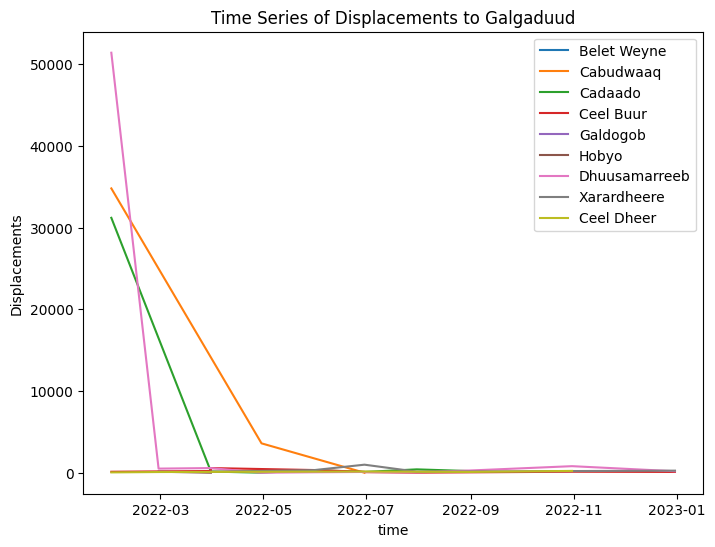

In [32]:
#disp_data_d=disp_data_d[disp_data_d['time'].dt.year==year]
# Filter the data for the specified region
region_data = disp_data_d[disp_data_d['Current (Arrival) Region'] == 'Galgaduud']

# Plotting the time series
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over each origin and plot the time series
for origin in districts:
    origin_data = region_data[region_data['Previous (Departure) District'] == origin]
    if origin_data['Number of Individuals'].sum() > 0:
        ax.plot(origin_data['time'], origin_data['Number of Individuals'], label=origin)

# Set the title and labels
ax.set_title(f"Time Series of Displacements to Galgaduud")
ax.set_xlabel("time")
ax.set_ylabel("Displacements")
ax.legend()
plt.show()

## Time Series of Displacements to {destination}

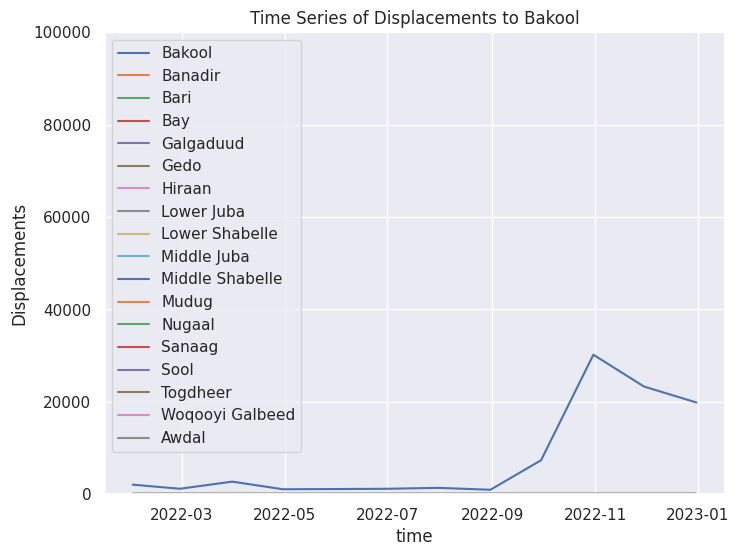

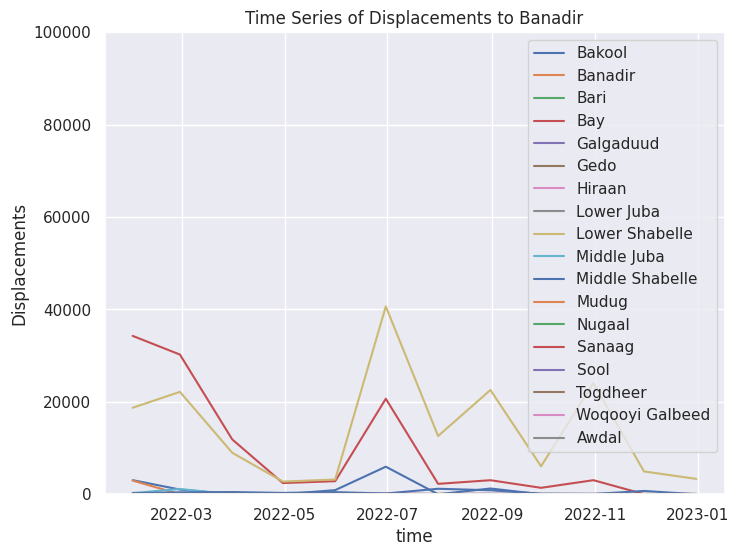

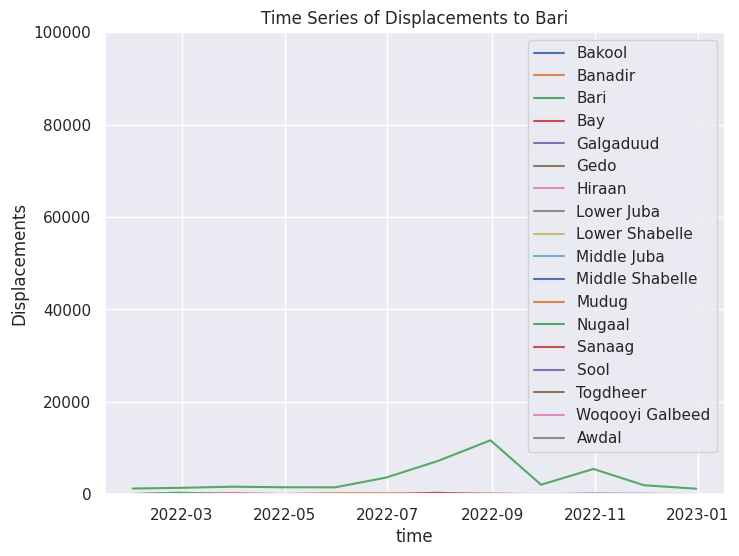

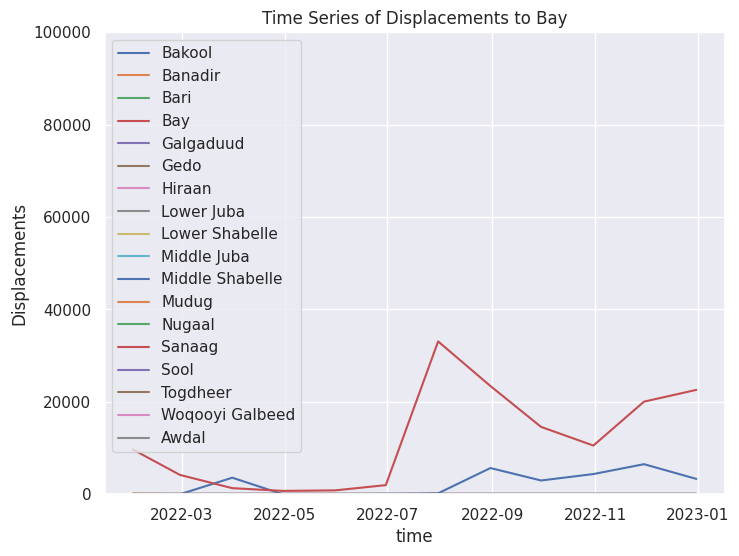

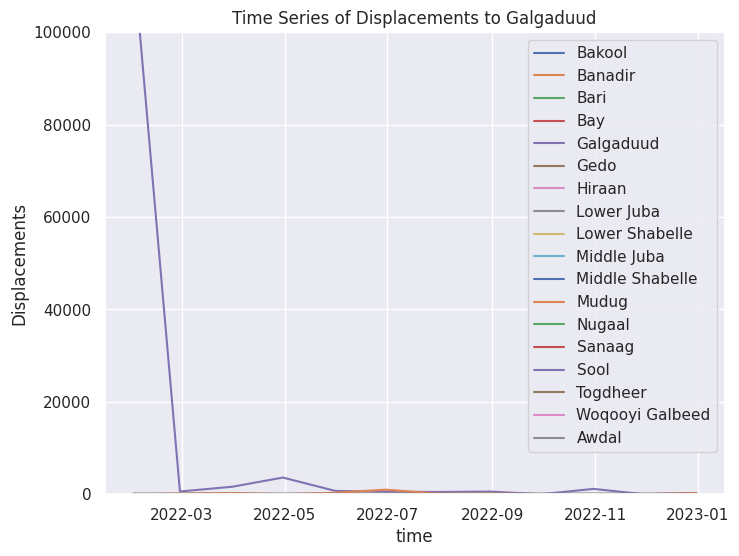

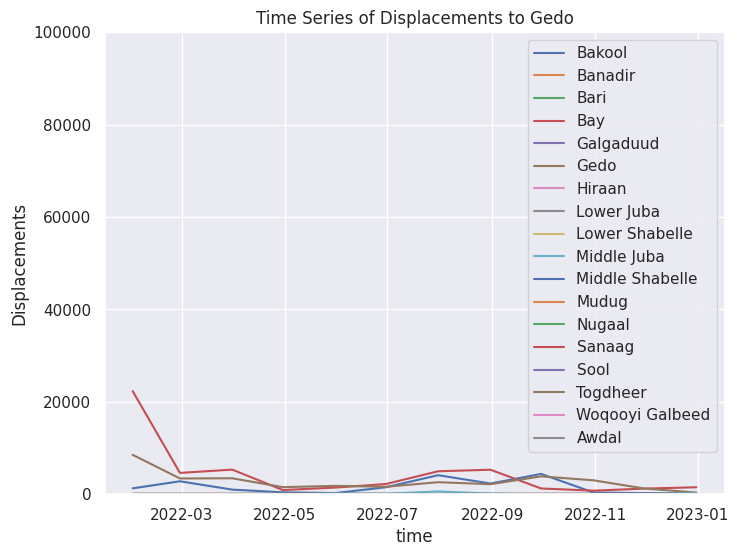

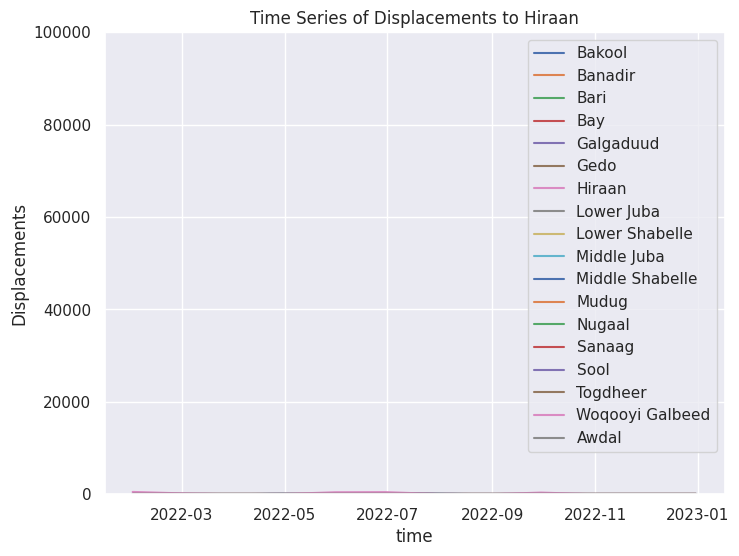

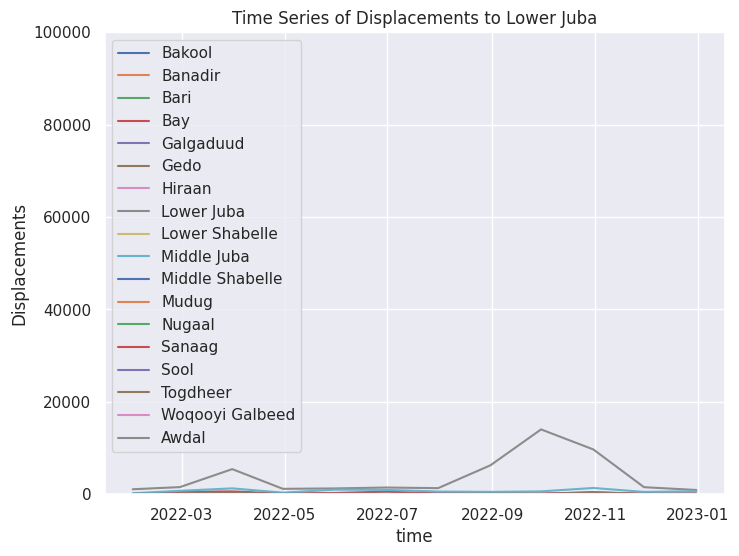

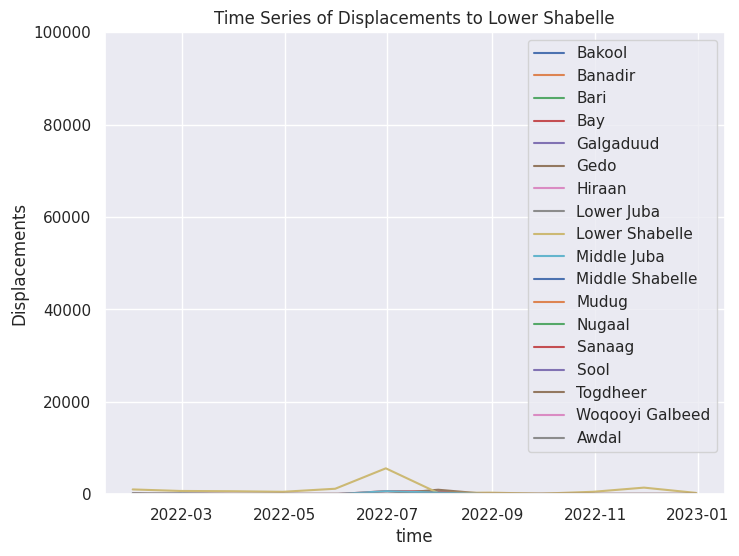

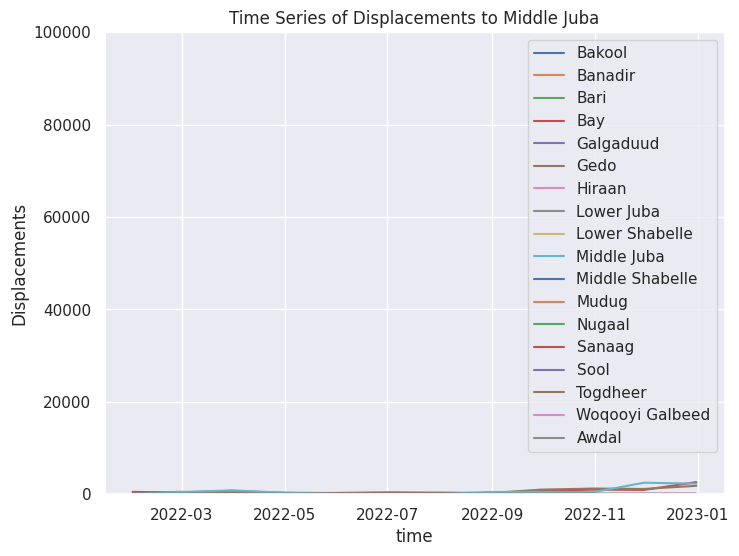

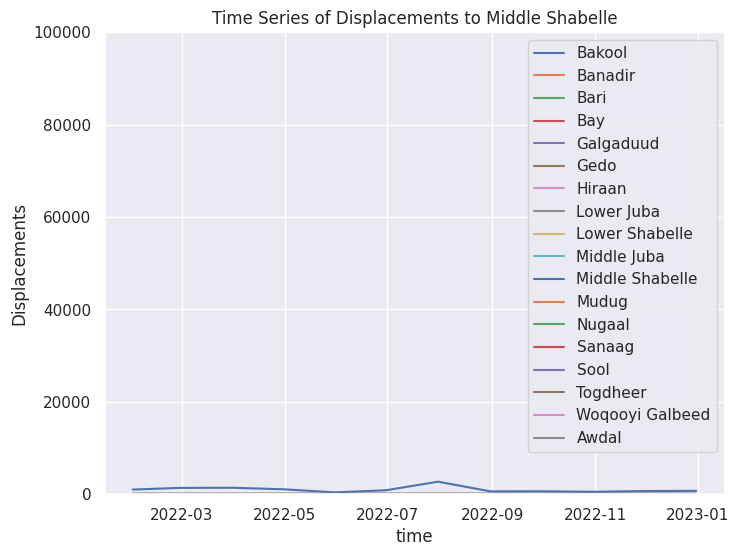

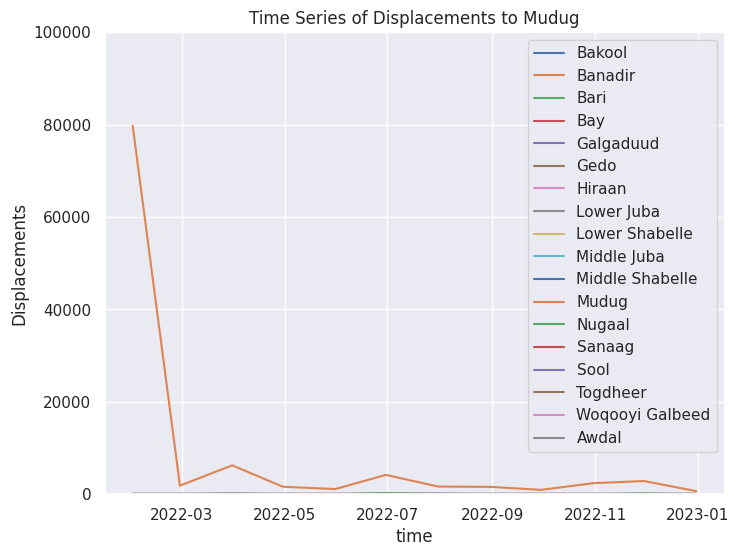

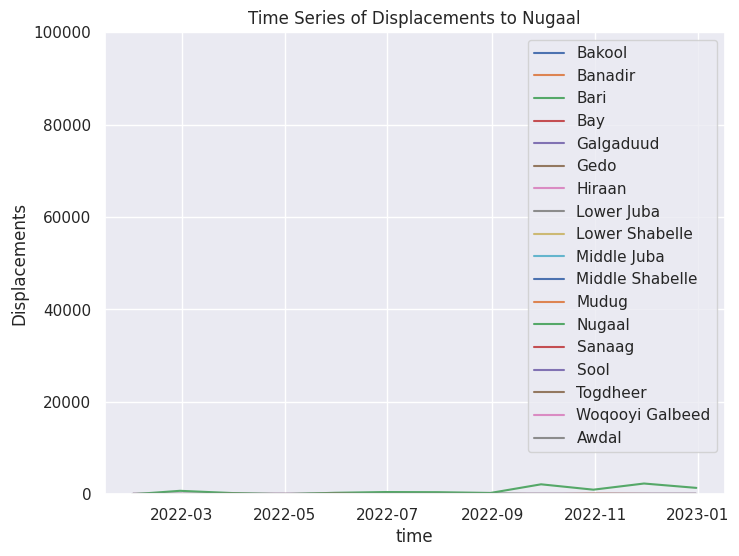

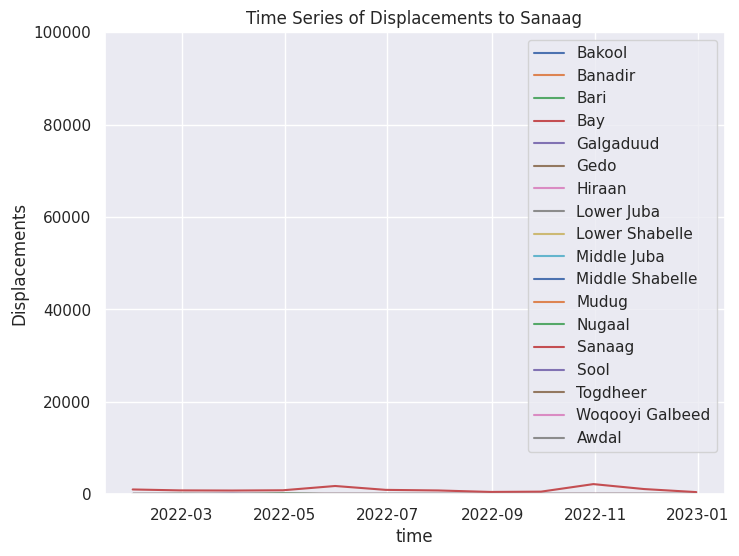

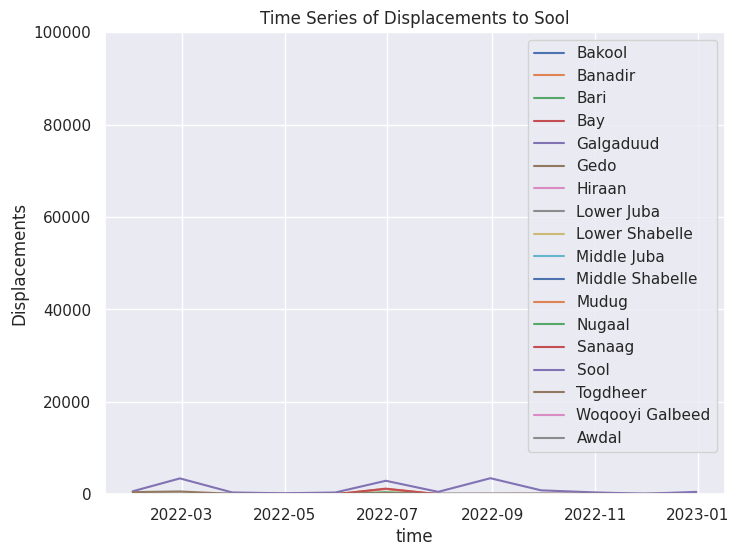

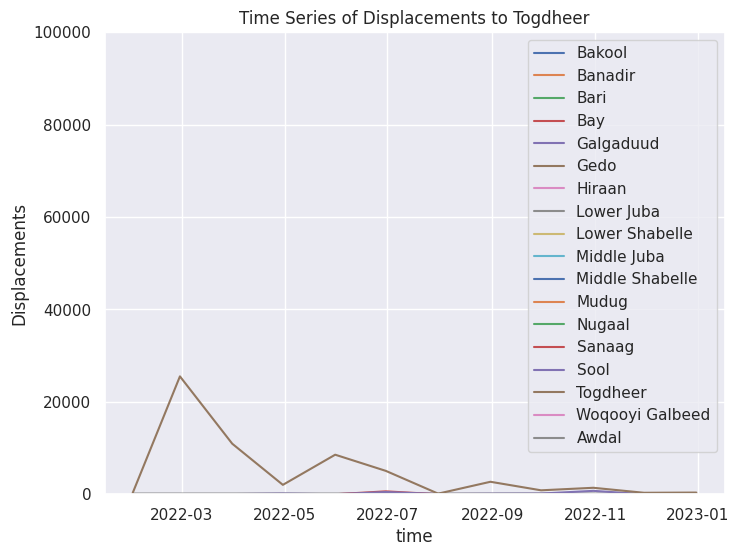

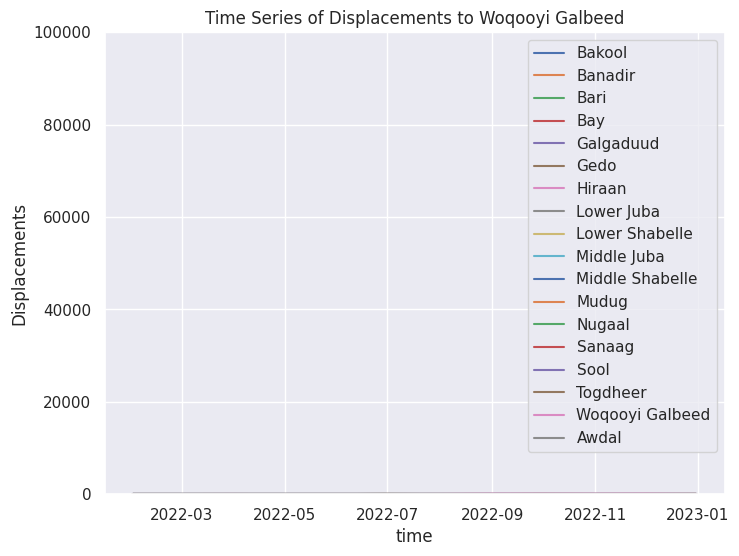

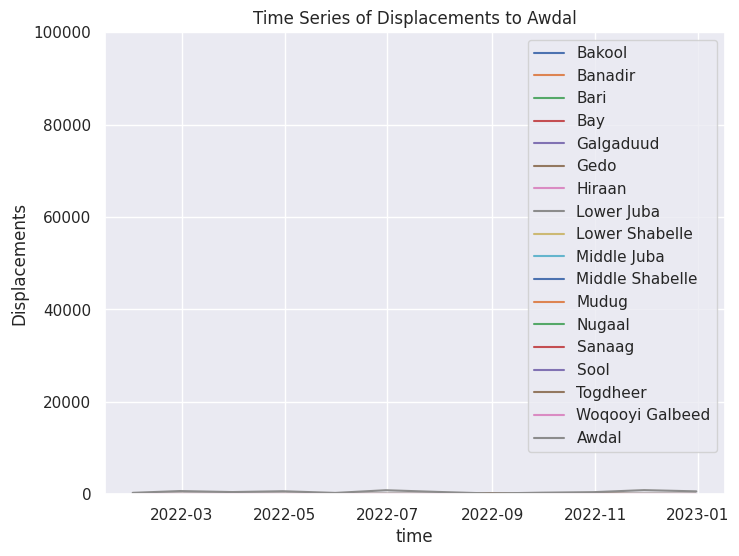

In [170]:
regions = disp_data['Previous (Departure) Region'].unique()

# Assuming you have a DataFrame called 'disp_data' with columns 'Previous (Departure) Region', 'Year', and 'Displacements'
for destination in regions:
    
    # Filter the data for the specified region
    region_data = disp_data[disp_data['Current (Arrival) Region'] == destination]

    # Plotting the time series
    fig, ax = plt.subplots(figsize=(8, 6))

    # Iterate over each origin and plot the time series
    for origin in regions:
        origin_data = region_data[region_data['Previous (Departure) Region'] == origin]
        ax.plot(origin_data['time'], origin_data['Number of Individuals'], label=origin)

    # Set the title and labels
    ax.set_title(f"Time Series of Displacements to {destination}")
    ax.set_xlabel("time")
    ax.set_ylabel("Displacements")
    ax.set_ylim(top=100000)
    ax.legend()
    plt.show()

In [175]:
regions

array(['Bakool', 'Banadir', 'Bari', 'Bay', 'Galgaduud', 'Gedo', 'Hiraan',
       'Lower Juba', 'Lower Shabelle', 'Middle Juba', 'Middle Shabelle',
       'Mudug', 'Nugaal', 'Sanaag', 'Sool', 'Togdheer', 'Woqooyi Galbeed',
       'Awdal'], dtype=object)

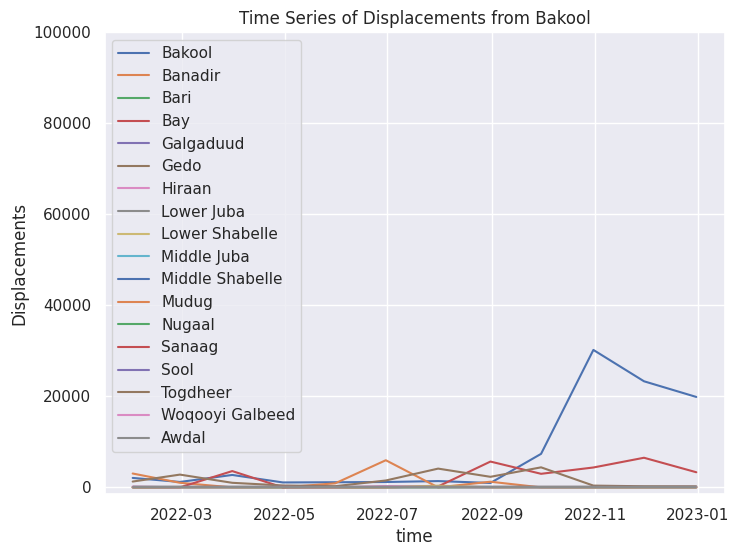

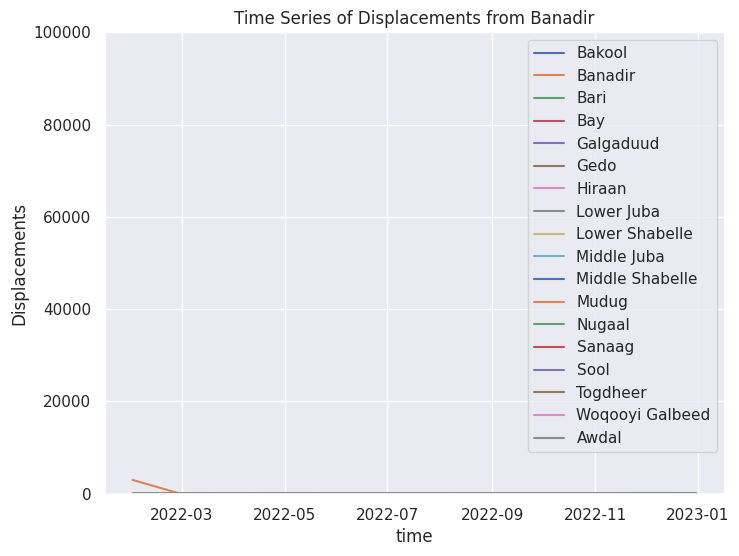

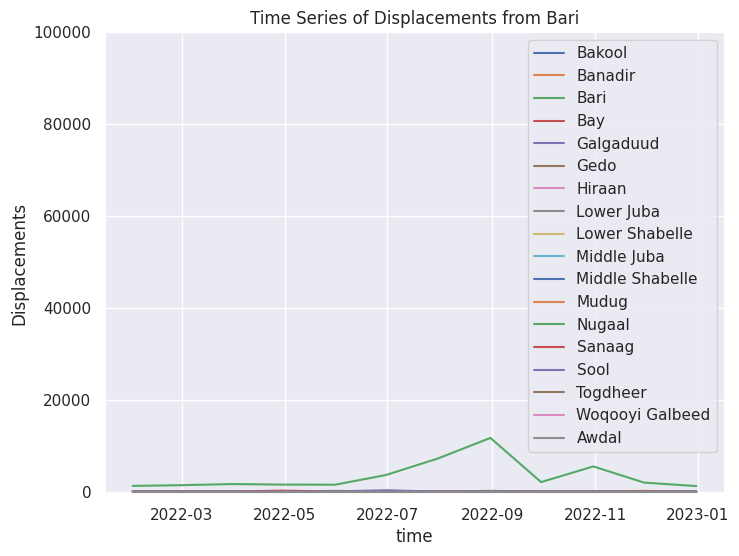

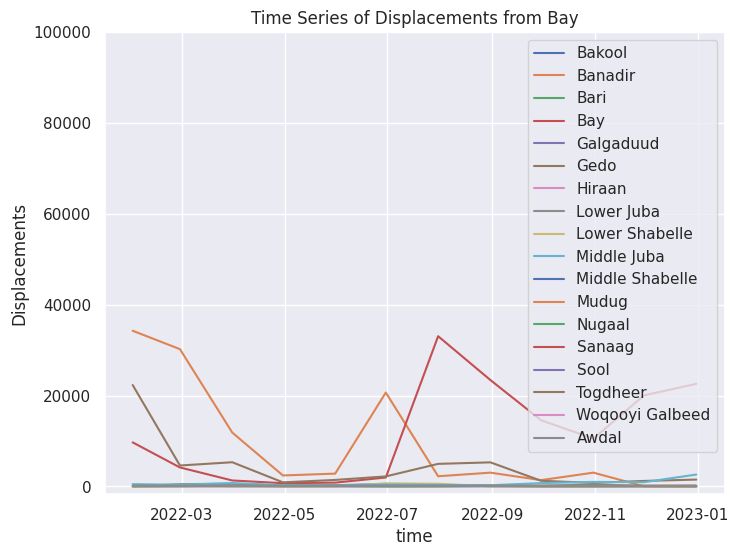

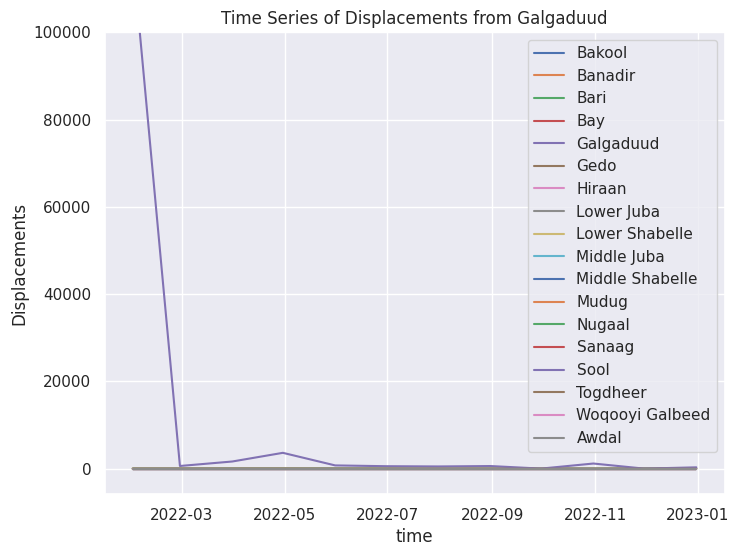

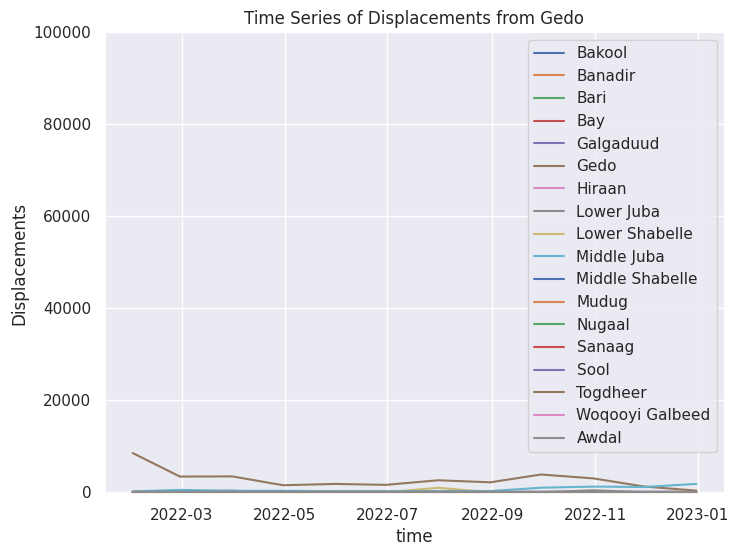

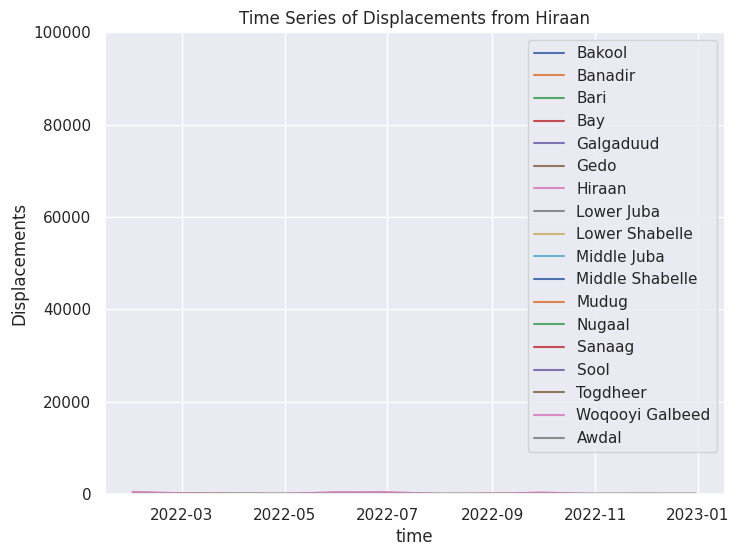

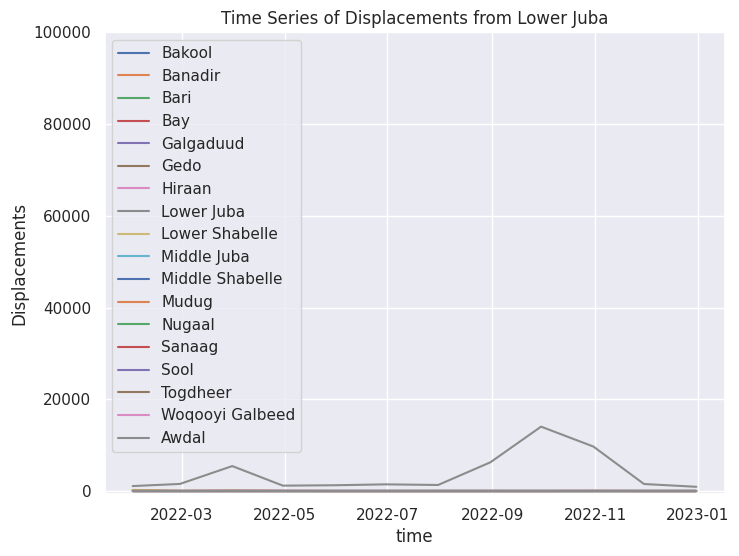

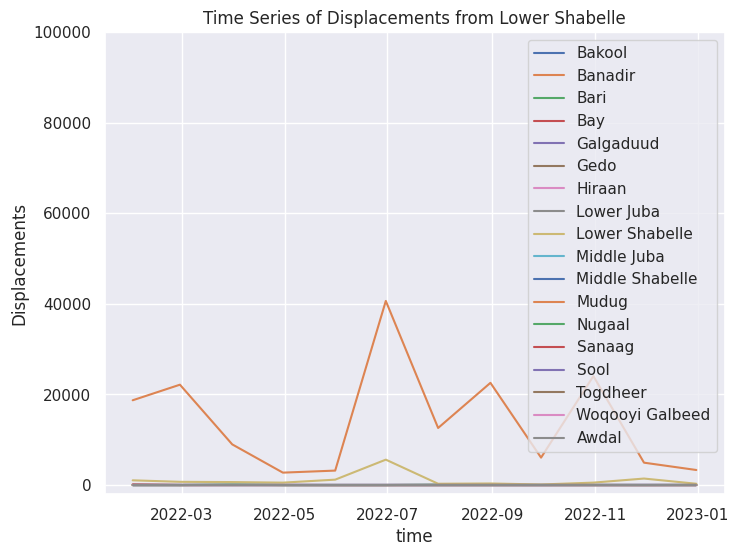

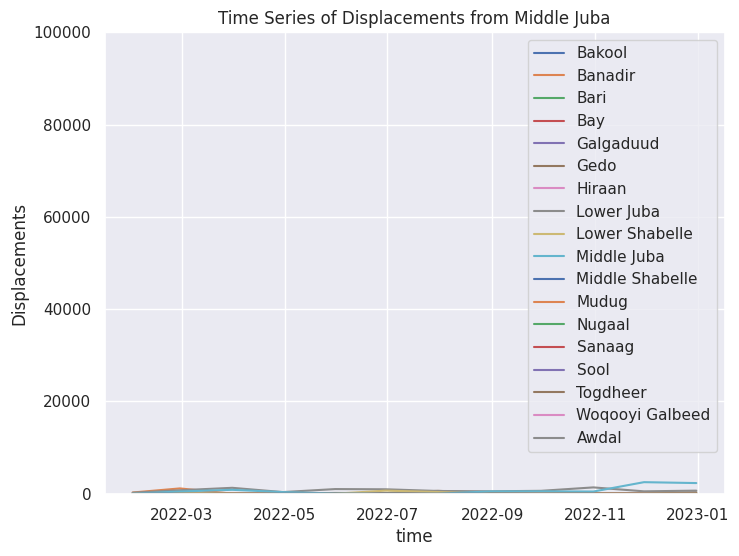

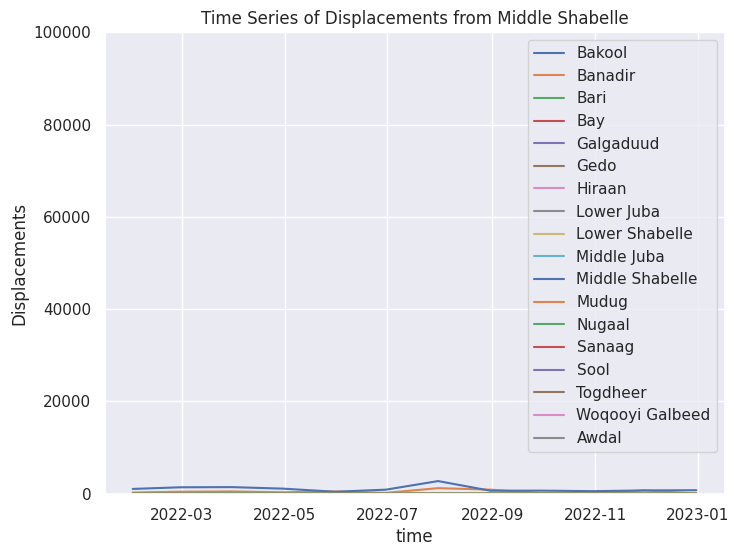

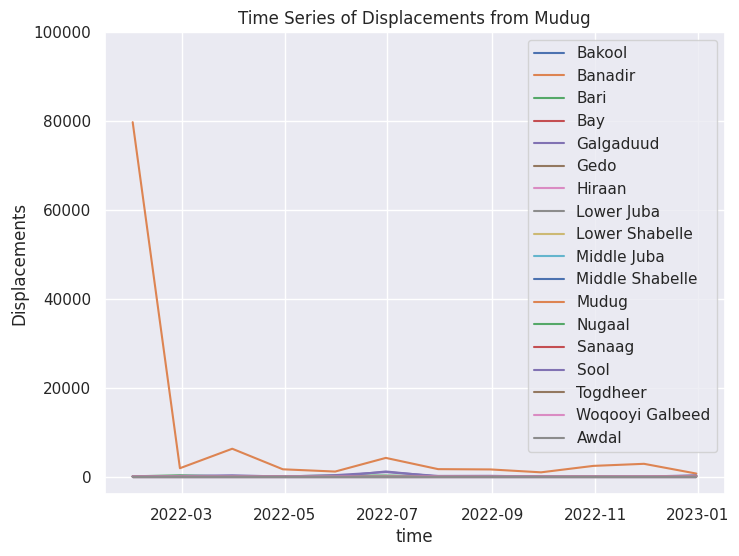

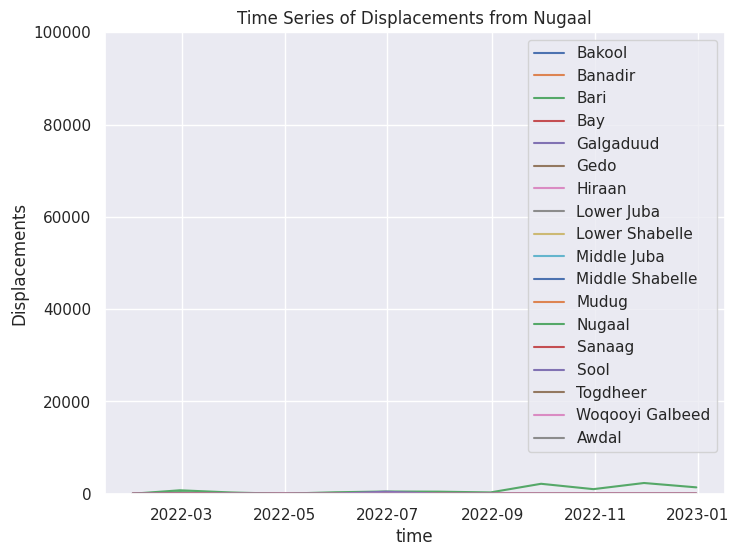

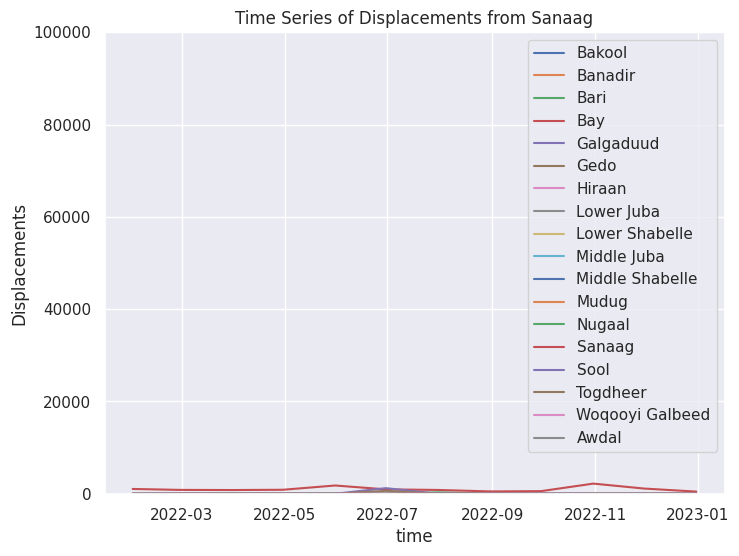

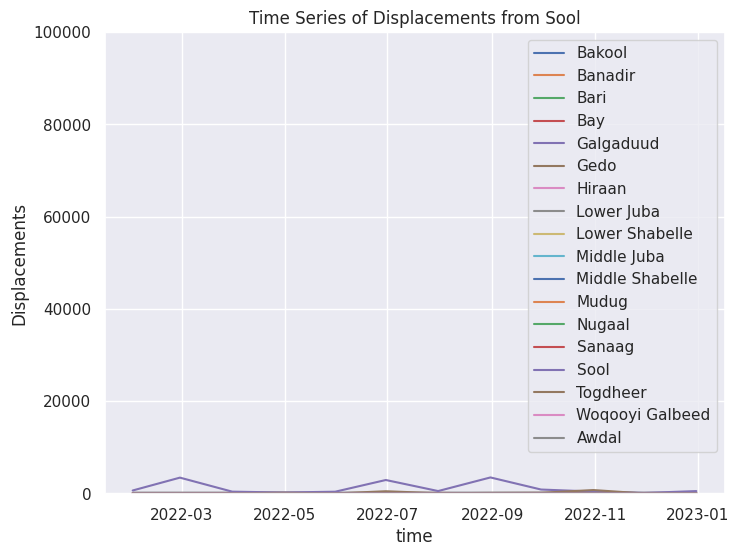

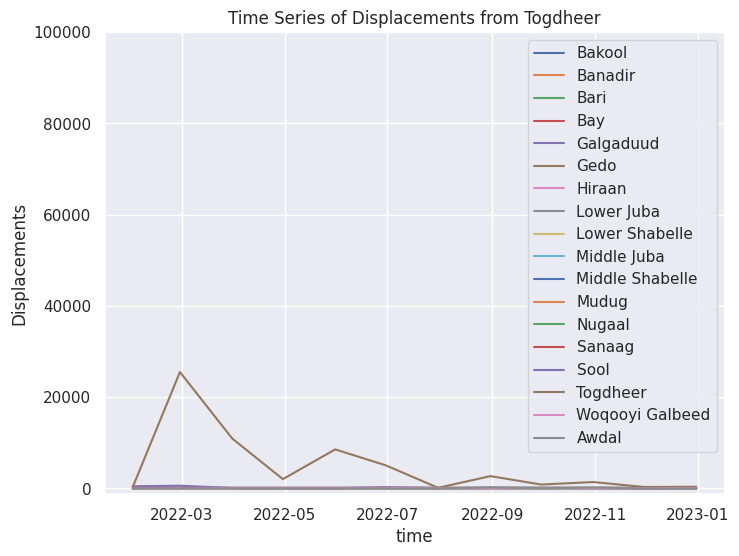

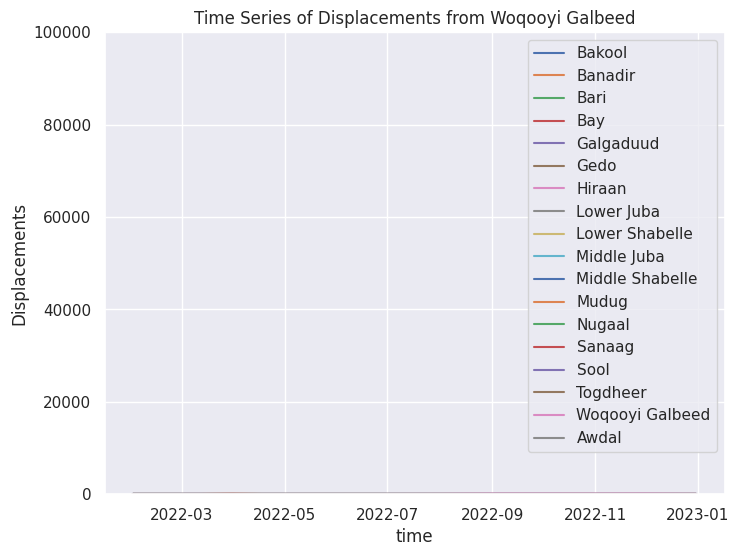

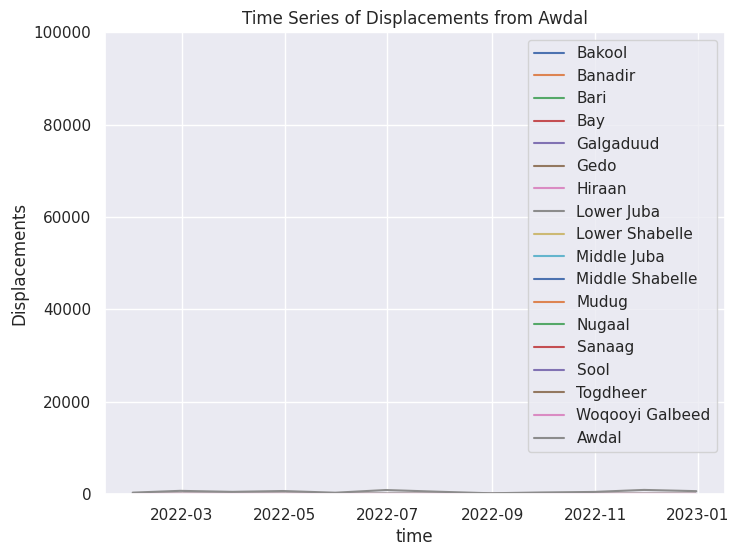

In [173]:
regions = disp_data['Previous (Departure) Region'].unique()

# Assuming you have a DataFrame called 'disp_data' with columns 'Previous (Departure) Region', 'Year', and 'Displacements'
for origin in regions:
    
    # Filter the data for the specified region
    region_data = disp_data[disp_data['Previous (Departure) Region'] == origin]

    # Plotting the time series
    fig, ax = plt.subplots(figsize=(8, 6))

    # Iterate over each origin and plot the time series
    for destination in regions:
        destination_data = region_data[region_data['Current (Arrival) Region'] == destination]
        ax.plot(destination_data['time'], destination_data['Number of Individuals'], label=destination)

    # Set the title and labels
    ax.set_title(f"Time Series of Displacements from {origin}")
    ax.set_xlabel("time")
    ax.set_ylabel("Displacements")
    ax.set_ylim(top=100000)
    ax.legend()
    plt.show()

In [174]:
destination_data

time Previous (Departure) Region Current (Arrival) Region  \
23651 2022-01-31                       Awdal                    Awdal   
23975 2022-02-28                       Awdal                    Awdal   
24299 2022-03-31                       Awdal                    Awdal   
24623 2022-04-30                       Awdal                    Awdal   
24947 2022-05-31                       Awdal                    Awdal   
25271 2022-06-30                       Awdal                    Awdal   
25595 2022-07-31                       Awdal                    Awdal   
25919 2022-08-31                       Awdal                    Awdal   
26243 2022-09-30                       Awdal                    Awdal   
26567 2022-10-31                       Awdal                    Awdal   
26891 2022-11-30                       Awdal                    Awdal   
27215 2022-12-31                       Awdal                    Awdal   

       Number of Individuals  
23651                    307  
23975                    691  
24299                    477  
24623                    655  
24947                    288  
25271                    871  
25595                    503  
25919                    167  
26243                    336  
26567                    453  
26891                    893  
27215                    625

## Plot timeseries

KeyError: 'Previous (Departure) Region'

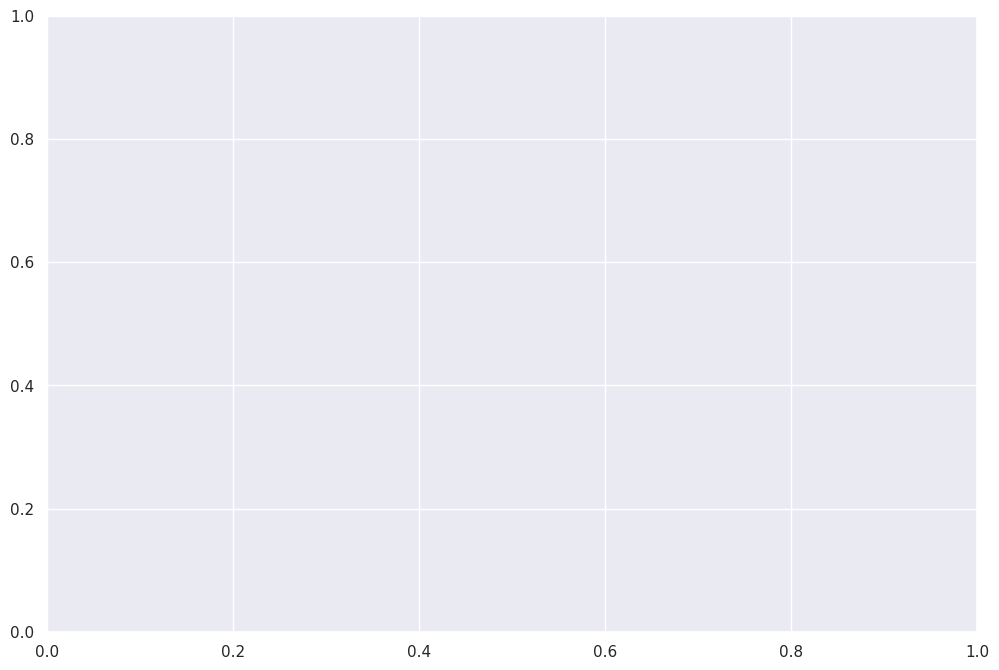

In [144]:
#plot timeseries of displacements for each region
fig, ax = plt.subplots(figsize=(12, 8))
for i, reg in enumerate(disp_matxs['Previous (Departure) Region'].unique()):
    disp_matxs[reg].groupby(['Previous (Departure) Region']).plot(legend=True)
    ax.set_ylabel('Displacements')
    ax.set_xlabel('Time')
    ax.set_title('Displacements in 2022 in '+str(regions[i]))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim(0,11)
    ax.set_ylim(0,100000)
    ax.grid(True)
    ax.show()

## Scatter plot 

$$
Disp_{ji} = f(\frac{TA_{lag2, i}}{dist^2_{ji}})
$$


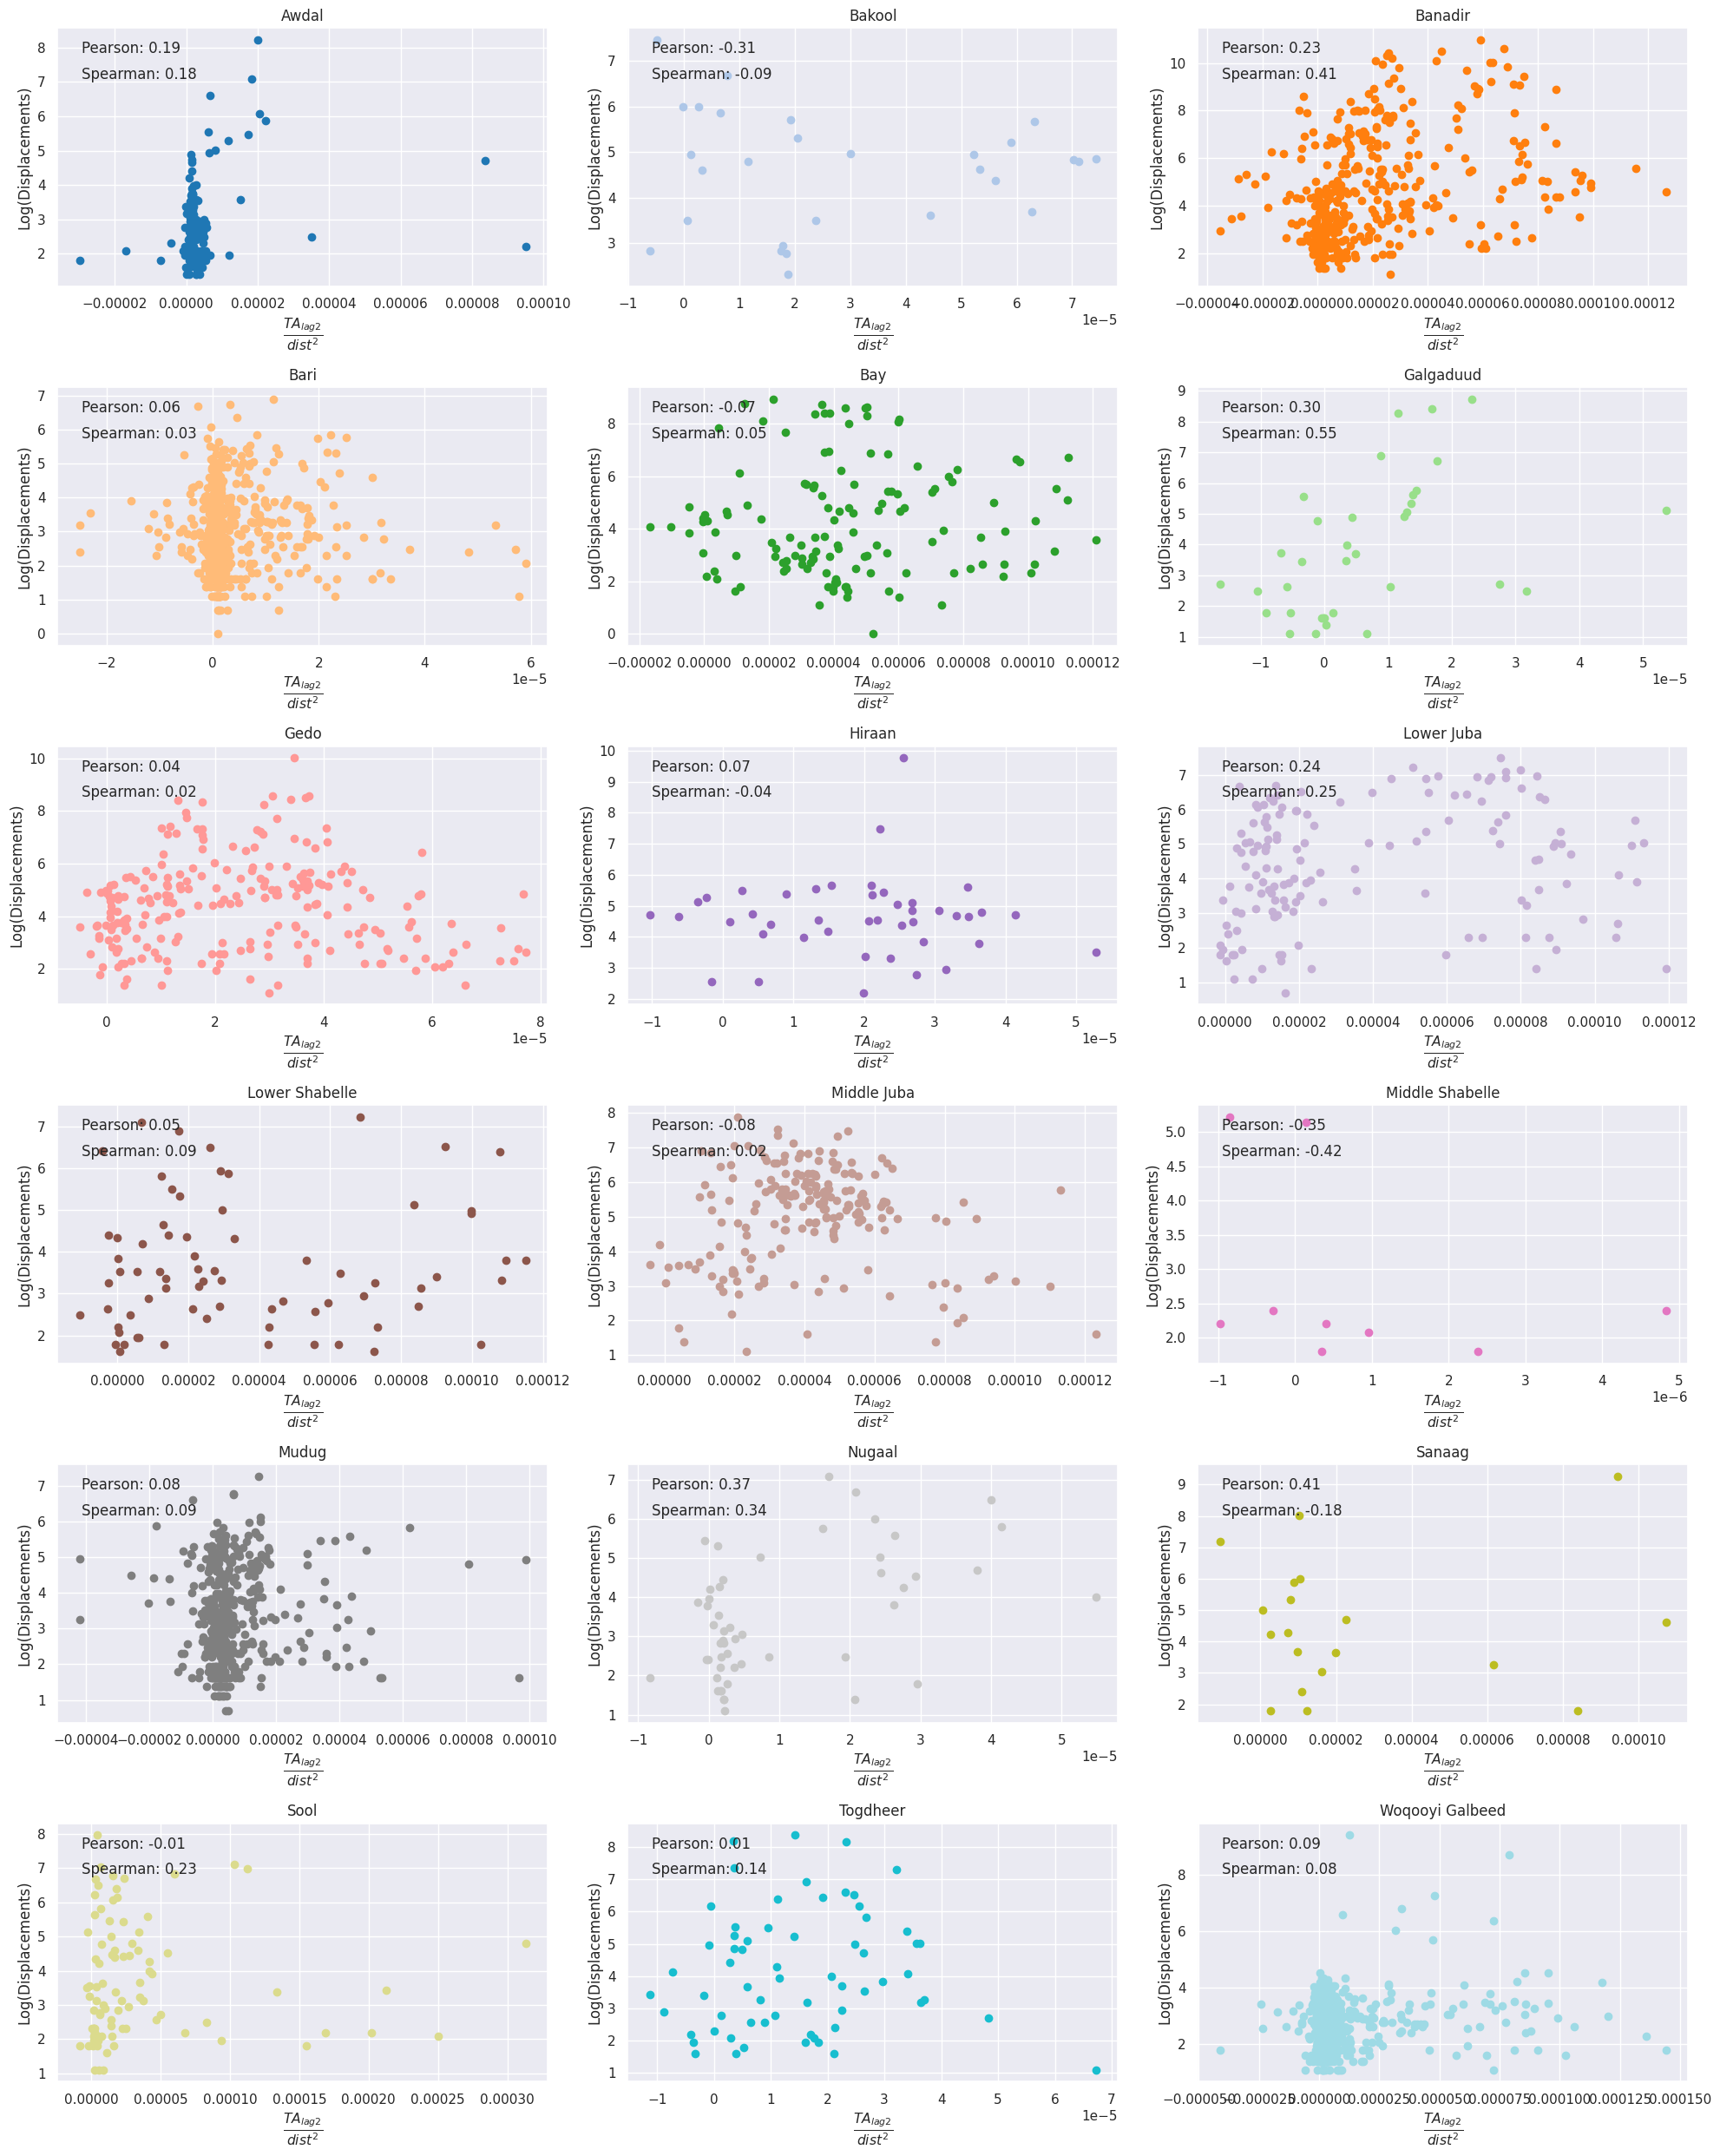

In [53]:
fig, axs = plt.subplots(6, 3, figsize=(20, 25))  

for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
            disp_reg['TA_lag2'] = df_m_y['TA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            color = cmap(region_codes[regions == j][0])
            axs[row, col].scatter(disp_reg['TA_lag2']*disp_reg['inv_dist']**2, np.log(disp_reg[j]), color=color)
        
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['inv_dist']*df_j['TA_lag2'])]
    df_j = df_j[df_j['inv_dist']*df_j['inv_dist']*df_j['TA_lag2'] != np.nan]

    
    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan

    axs[row, col].set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist^2}}$', fontsize=16)
    axs[row, col].set_ylabel('Log(Displacements)')
    axs[row, col].set_title(j)
    axs[row, col].text(0.05, 0.95, f"Pearson: {corr_pearson:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    axs[row, col].text(0.05, 0.85, f"Spearman: {corr_spearman:.2f}", transform=axs[row, col].transAxes, ha='left', va='top')
    
plt.tight_layout()
plt.show()

## Jointplot 

$$
Log(Disp_{ji}) = f(\frac{TA_{lag2, i}}{dist_{ji}})
$$

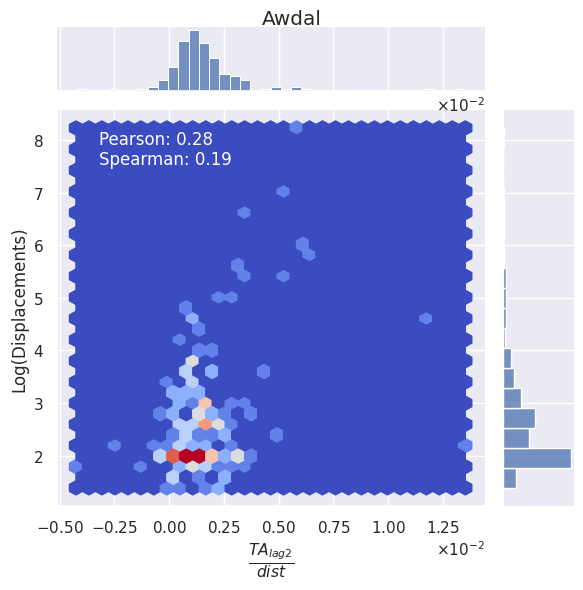

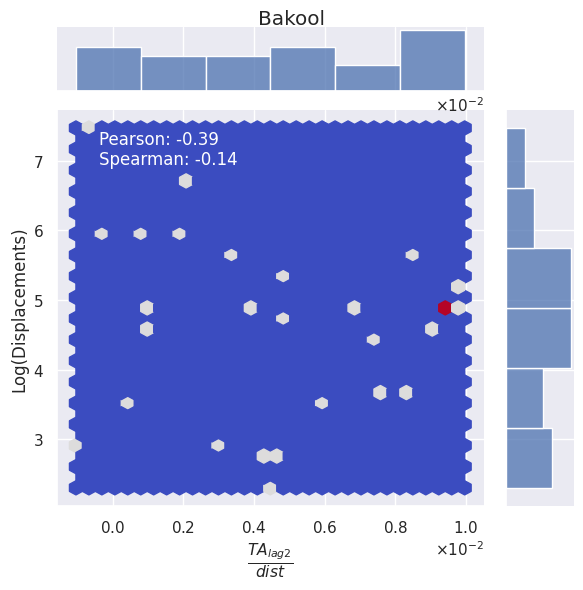

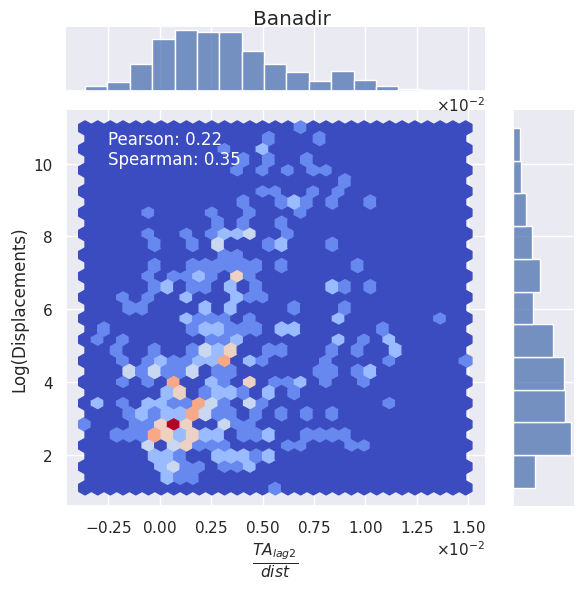

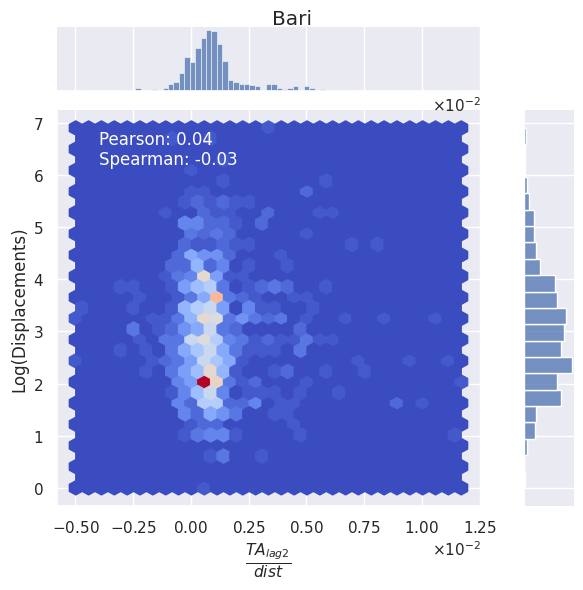

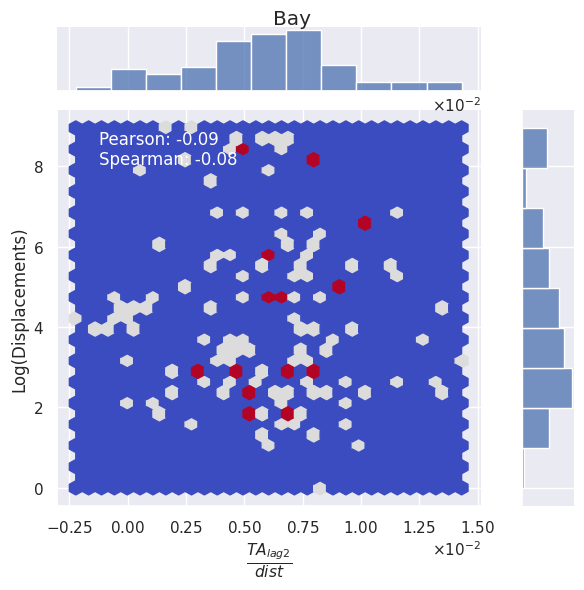

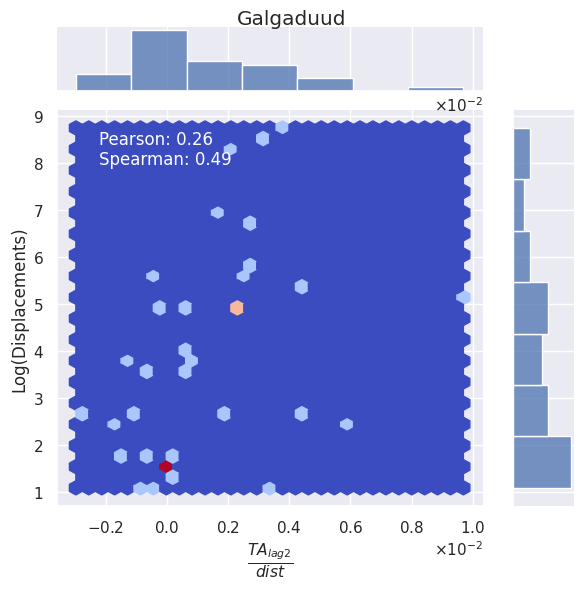

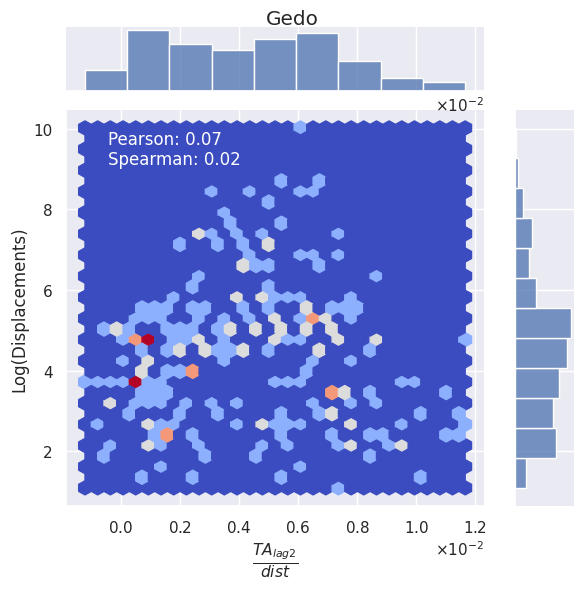

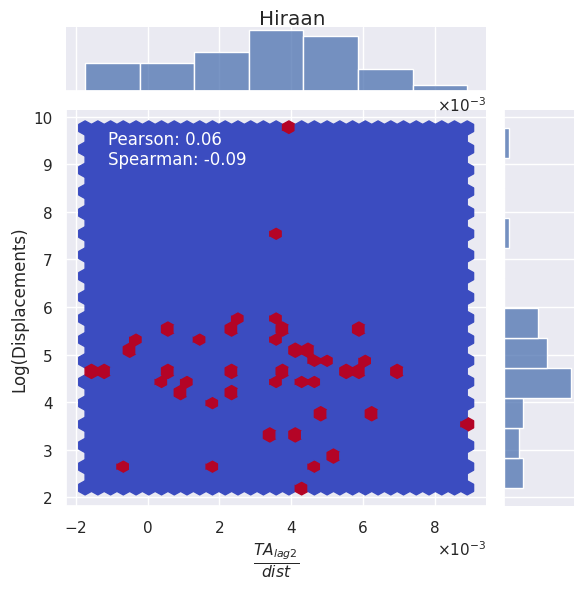

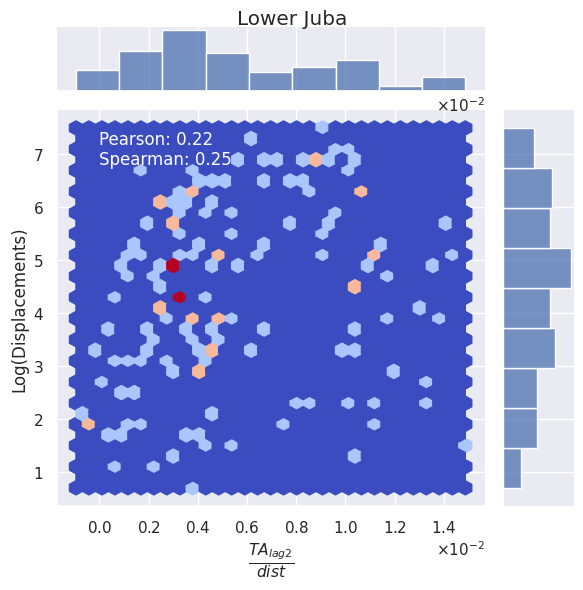

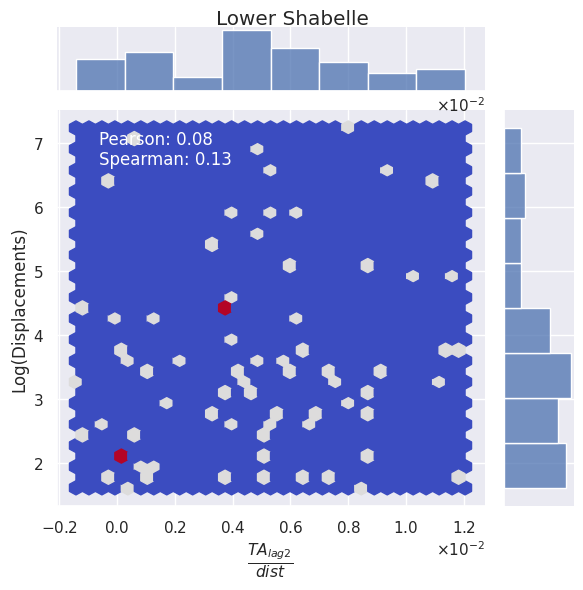

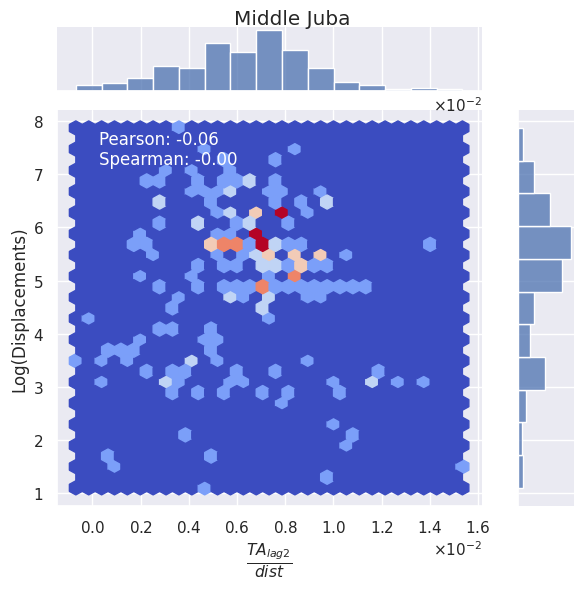

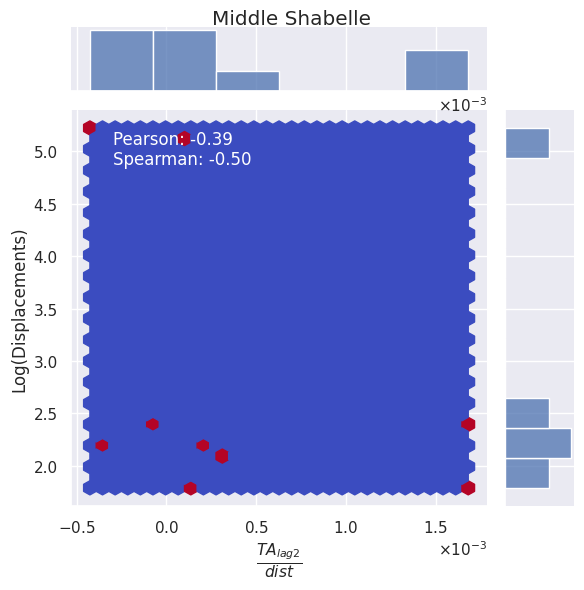

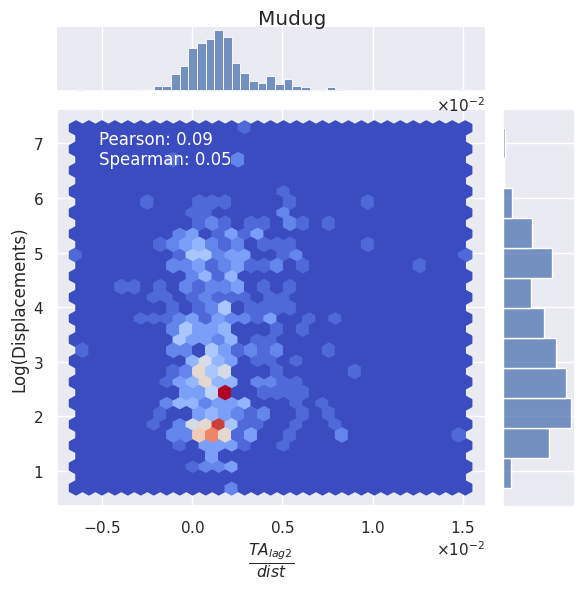

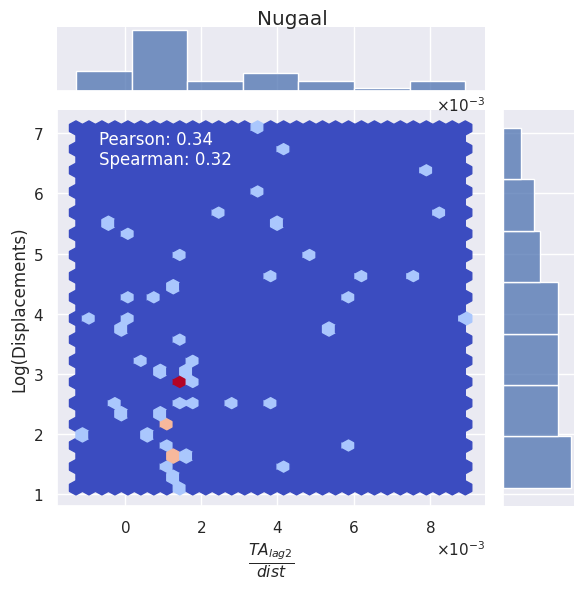

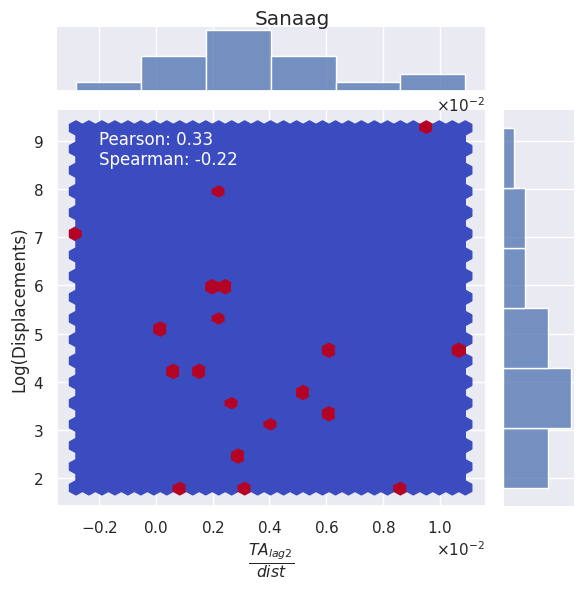

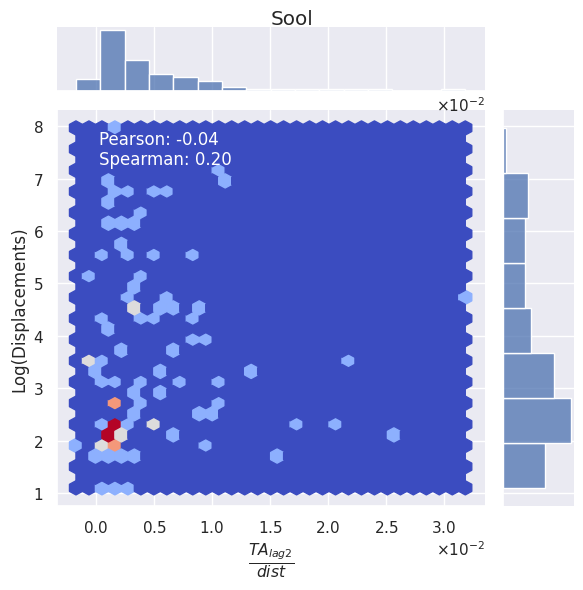

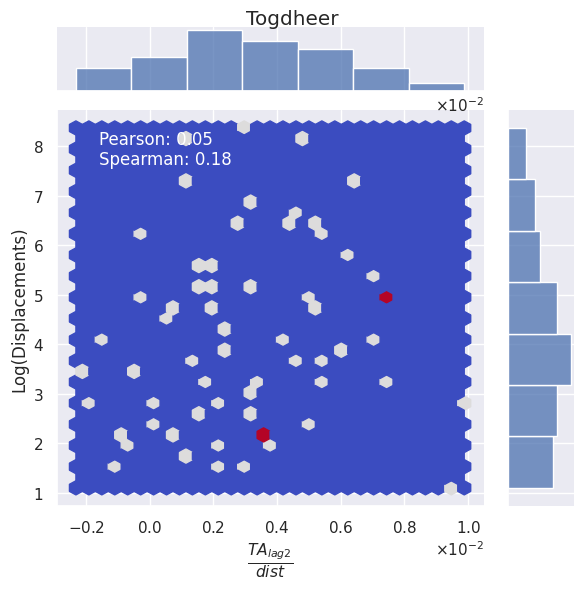

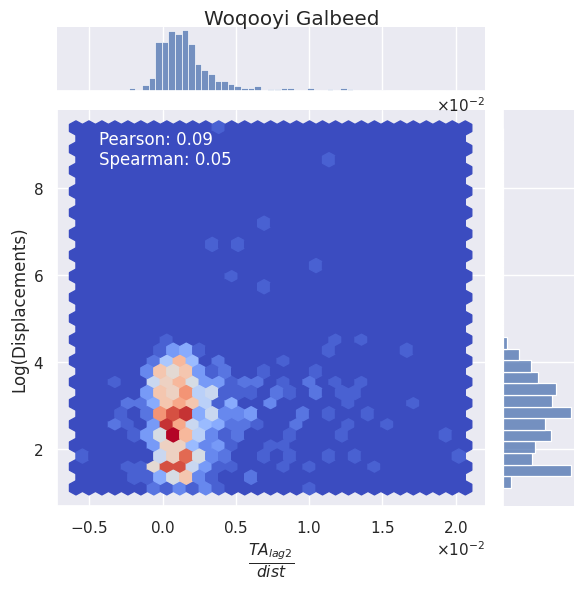

In [54]:
for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
            disp_reg['TA_lag2'] = df_m_y['TA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag2'])]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['inv_dist']*df_j['TA_lag2'], df_j[j])
        corr_spearman, _ = spearmanr(df_j['inv_dist']*df_j['TA_lag2'], df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j['TA_lag2']*df_j['inv_dist']

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist}}$', fontsize=16)
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    g.ax_joint.xaxis.set_major_formatter(formatter)
    
plt.show()

## Jointplot 

$$
Log(Disp_{ji}) = f(\frac{TA_i}{dist^2_{ji}})
$$

In [107]:
disp_data[disp_data['time'].astype(str).str[0:4]=='2022']['Number of Individuals'].sum()

1179371

In [113]:
disp_data_22= disp_data[disp_data['time'].astype(str).str[0:4]=='2022']

In [126]:
disp_data_22[disp_data_22['Current (Arrival) Region']=='Banadir']

time Previous (Departure) Region Current (Arrival) Region  \
23329 2022-01-31                      Bakool                  Banadir   
23347 2022-01-31                     Banadir                  Banadir   
23365 2022-01-31                        Bari                  Banadir   
23383 2022-01-31                         Bay                  Banadir   
23401 2022-01-31                   Galgaduud                  Banadir   
...          ...                         ...                      ...   
27127 2022-12-31                      Sanaag                  Banadir   
27145 2022-12-31                        Sool                  Banadir   
27163 2022-12-31                    Togdheer                  Banadir   
27181 2022-12-31             Woqooyi Galbeed                  Banadir   
27199 2022-12-31                       Awdal                  Banadir   

       Number of Individuals  
23329                   3048  
23347                   2952  
23365                      0  
23383                  34277  
23401                     18  
...                      ...  
27127                      0  
27145                      0  
27163                      0  
27181                      0  
27199                      0  

[216 rows x 4 columns]

In [115]:
disp_data_22['Number of Individuals'].sum()

1179371

In [119]:
#sum all the displacements in 2022
disp_data_22.pivot_table(index=['time','Previous (Departure) Region'], columns='Current (Arrival) Region', values='Number of Individuals', aggfunc='sum')
#sum all the displacements in 2022
disp_matxs.sum(axis=0)

Current (Arrival) Region
Awdal                6758
Bakool              92486
Banadir            305155
Bari                44525
Bay                170073
Galgaduud          129509
Gedo               105910
Hiraan               2720
Lower Juba          58952
Lower Shabelle      17348
Middle Juba         24028
Middle Shabelle     12093
Mudug              106024
Nugaal              10162
Sanaag              12382
Sool                19011
Togdheer            60706
Woqooyi Galbeed      1529
year               436752
dtype: int64

In [87]:
disp_matxs

Current (Arrival) Region                Awdal  Bakool  Banadir  Bari   Bay  \
time       Previous (Departure) Region                                       
2022-01-31 Awdal                          307       0        0     0     0   
           Bakool                           0    2077     3048     6     0   
           Banadir                          0       0     2952    48     0   
           Bari                             0       0        0  1236     0   
           Bay                              0       0    34277    30  9705   
...                                       ...     ...      ...   ...   ...   
2022-12-31 Nugaal                           0       0        0     6     0   
           Sanaag                           0       0        0     8     0   
           Sool                             0       0        0    29     0   
           Togdheer                         0       0        0     0     0   
           Woqooyi Galbeed                  0       0        0     0     0   

Current (Arrival) Region                Galgaduud   Gedo  Hiraan  Lower Juba  \
time       Previous (Departure) Region                                         
2022-01-31 Awdal                                0      0       0           0   
           Bakool                               0   1278     165           0   
           Banadir                              0      0       0           0   
           Bari                                 0      0       0           0   
           Bay                                  0  22329       0          44   
...                                           ...    ...     ...         ...   
2022-12-31 Nugaal                               0      0       0           0   
           Sanaag                               0      0       0           0   
           Sool                                 0      0       0           0   
           Togdheer                             0      0       0           0   
           Woqooyi Galbeed                      0      0       0           0   

Current (Arrival) Region                Lower Shabelle  Middle Juba  \
time       Previous (Departure) Region                                
2022-01-31 Awdal                                     0            0   
           Bakool                                   14            0   
           Banadir                                   0            0   
           Bari                                      0            0   
           Bay                                       0          516   
...                                                ...          ...   
2022-12-31 Nugaal                                    0            0   
           Sanaag                                    0            0   
           Sool                                      0            0   
           Togdheer                                  0            0   
           Woqooyi Galbeed                           0            0   

Current (Arrival) Region                Middle Shabelle  Mudug  Nugaal  \
time       Previous (Departure) Region                                   
2022-01-31 Awdal                                      0      0       0   
           Bakool                                     0      0       0   
           Banadir                                    0      0       0   
           Bari                                       0      0       0   
           Bay                                        0      0       0   
...                                                 ...    ...     ...   
2022-12-31 Nugaal                                     0      0    1378   
           Sanaag                                     0      0       0   
           Sool                                       0      0       0   
           Togdheer                                   0      0       0   
           Woqooyi Galbeed                            0      0       0   

Current (Arrival) Region                Sanaag  Sool  Tog

In [81]:
df_j

time Previous (Departure) Region  Woqooyi Galbeed  inv_dist  \
0  2022-01-31                      Sanaag         1.098612  0.002864   
1  2022-01-31                        Sool         1.791759  0.002925   
2  2022-01-31                    Togdheer         2.397895  0.006971   
4  2022-02-28                       Mudug         1.609438  0.002074   
5  2022-02-28                        Sool         2.302585  0.002925   
6  2022-02-28                    Togdheer         2.772589  0.006971   
8  2022-03-31                      Nugaal         2.302585  0.001988   
9  2022-03-31                      Sanaag         2.079442  0.002864   
10 2022-03-31                        Sool         2.944439  0.002925   
11 2022-03-31                    Togdheer         3.258097  0.006971   
13 2022-04-30                      Nugaal         2.302585  0.001988   
14 2022-04-30                      Sanaag         2.079442  0.002864   
15 2022-04-30                    Togdheer         3.044522  0.006971   
17 2022-05-31                      Nugaal         1.609438  0.001988   
18 2022-05-31                      Sanaag         2.079442  0.002864   
19 2022-05-31                        Sool         1.609438  0.002925   
20 2022-05-31                    Togdheer         3.258097  0.006971   
22 2022-06-30                      Nugaal         2.197225  0.001988   
23 2022-06-30                      Sanaag         3.295837  0.002864   
24 2022-06-30                        Sool         2.944439  0.002925   
25 2022-06-30                    Togdheer         4.234107  0.006971   
27 2022-07-31                       Mudug         1.791759  0.002074   
28 2022-07-31                      Nugaal         1.609438  0.001988   
29 2022-07-31                        Sool         2.639057  0.002925   
30 2022-07-31                    Togdheer         3.433987  0.006971   
32 2022-08-31                      Nugaal         2.302585  0.001988   
33 2022-08-31                        Sool         1.098612  0.002925   
34 2022-08-31                    Togdheer         3.496508  0.006971   
36 2022-09-30                       Mudug         1.609438  0.002074   
37 2022-09-30                      Nugaal         1.945910  0.001988   
38 2022-09-30                      Sanaag         1.791759  0.002864   
39 2022-09-30                        Sool         2.484907  0.002925   
40 2022-09-30                    Togdheer         4.110874  0.006971   
42 2022-10-31                       Mudug         2.397895  0.002074   
43 2022-10-31                      Nugaal         1.386294  0.001988   
44 2022-10-31                      Sanaag         2.079442  0.002864   
45 2022-10-31                        Sool         3.178054  0.002925   
46 2022-10-31                    Togdheer         3.806662  0.006971   
48 2022-11-30                       Mudug         2.890372  0.002074   
49 2022-11-30                      Nugaal         2.079442  0.001988   
50 2022-11-30                      Sanaag         1.609438  0.002864   
51 2022-11-30                    Togdheer         3.850148  0.006971   
53 2022-12-31                        Sool         2.564949  0.002925   
54 2022-12-31                    Togdheer         4.127134  0.006971   

     TA_lag2             x  
0   0.917817  7.526456e-06  
1   0.636919  5.447419e-06  
2   0.787171  3.825147e-05  
4   0.139334  5.995335e-07  
5   0.668075  5.713889e-06  
6   0.750838  3.648592e-05  
8   0.699843  2.766145e-06  
9   1.246164  1.021902e-05  
10  1.108053  9.476914e-06  
11  1.139509  5.537284e-05  
13  0.918068  3.628681e-06  
14  1.578740  1.294628e-05  
15  1.758926  8.547254e-05  
17  0.652529  2.579135e-06  
18  1.323901  1.085650e-05  
19  1.333713  1.140693e-05  
20  1.840610  8.944184e-05  
22  0.412290  1.629586e-06  
23  1.065479  8.737335e-06  
24  1.068230  9.136319e-06  
25  1.689585  8.210302e-05  
27  0.407661  1.754109e-06  
28  0.650635  2.571648e-06  
29  1.241766  1.062053e-05  
30  1.765110  8.577304e-05  
32  0.677699  

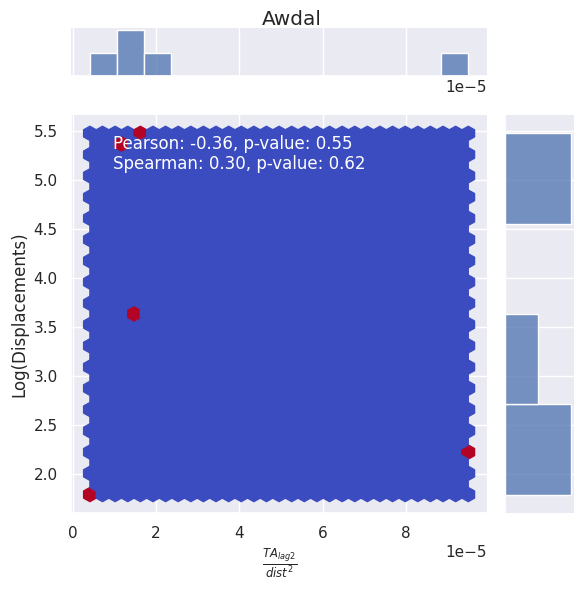

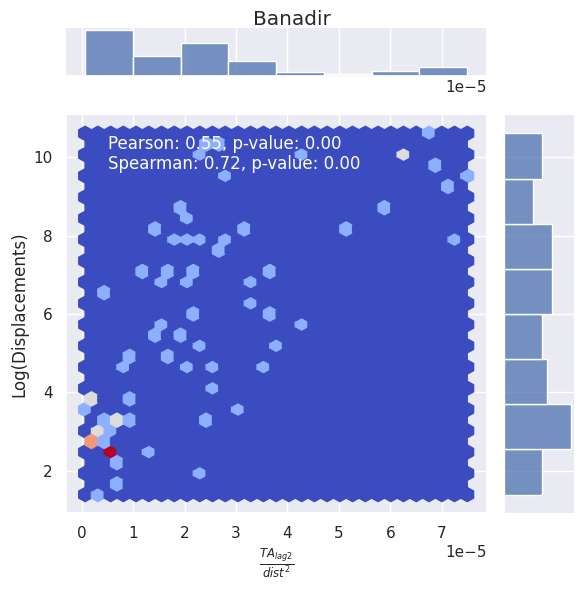

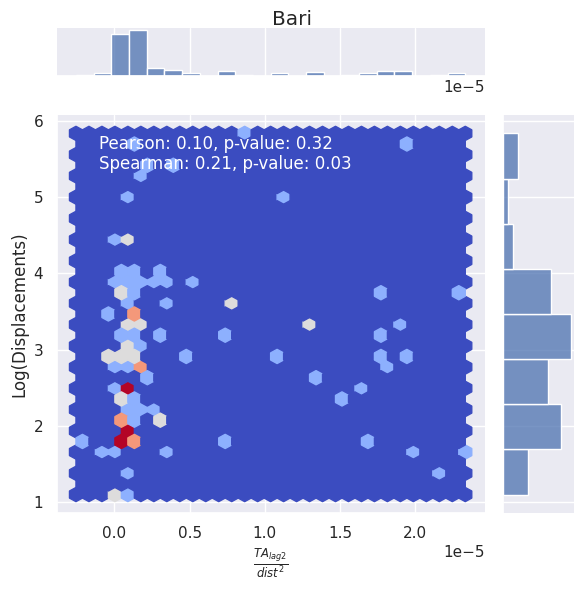

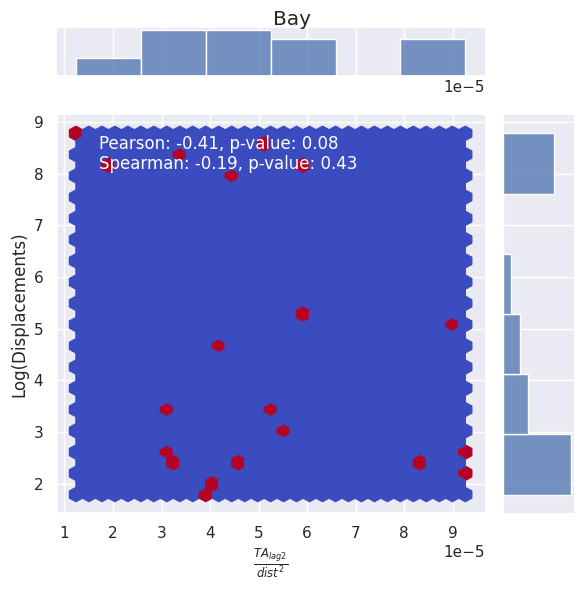

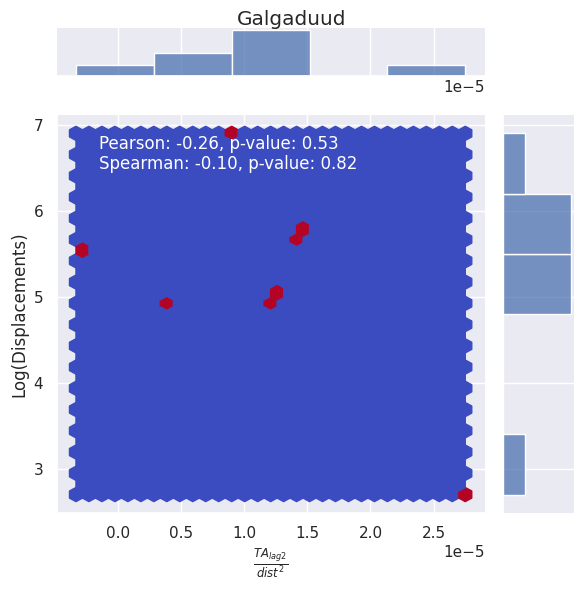

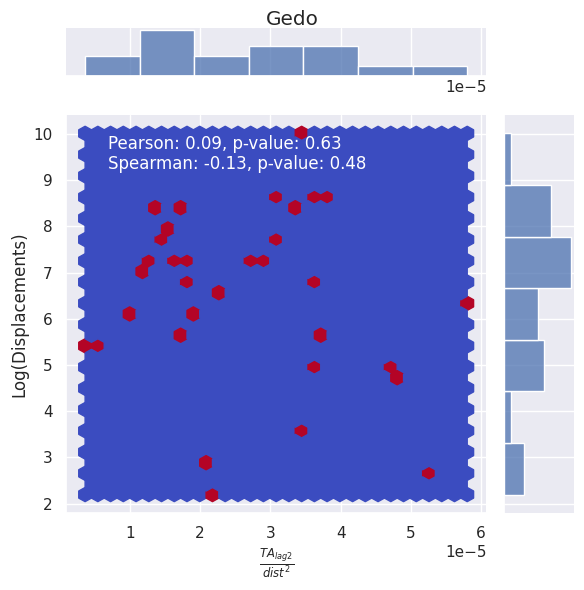

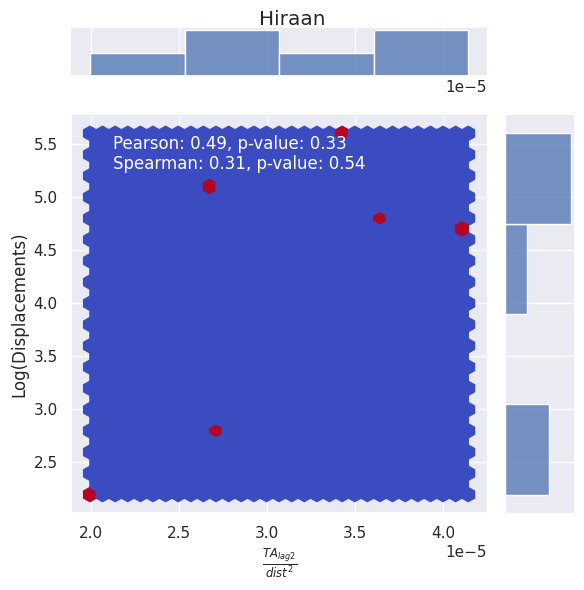

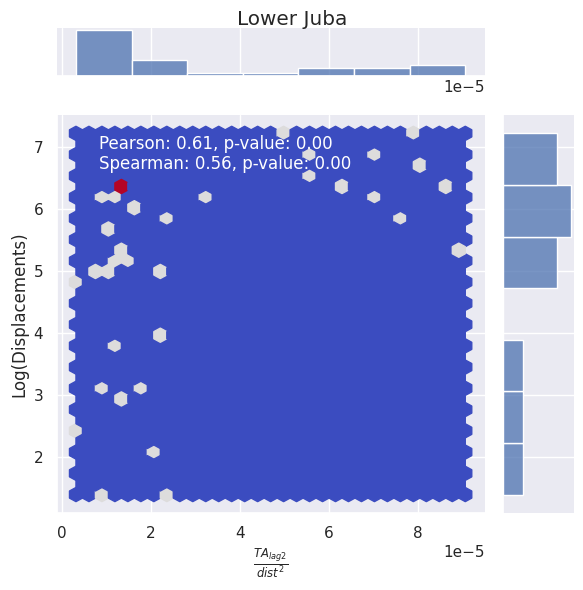

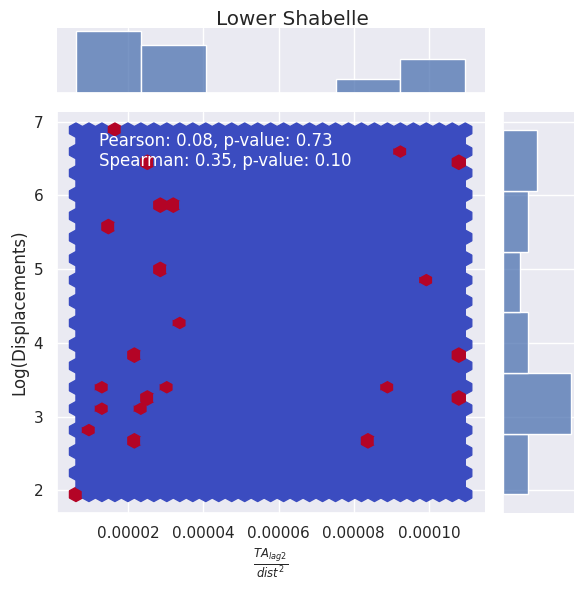

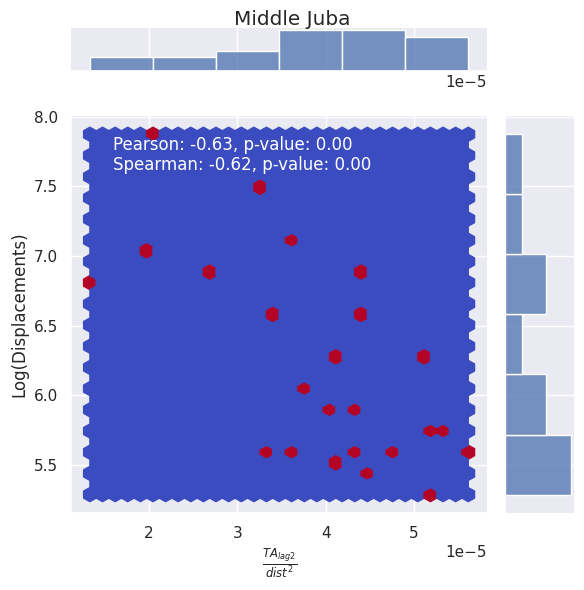

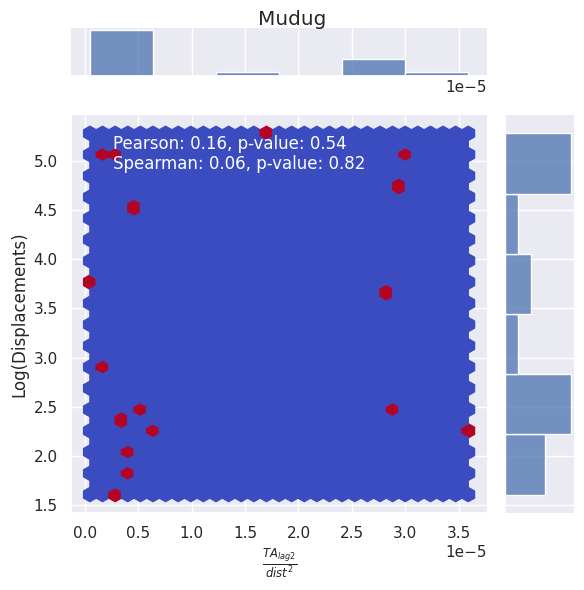

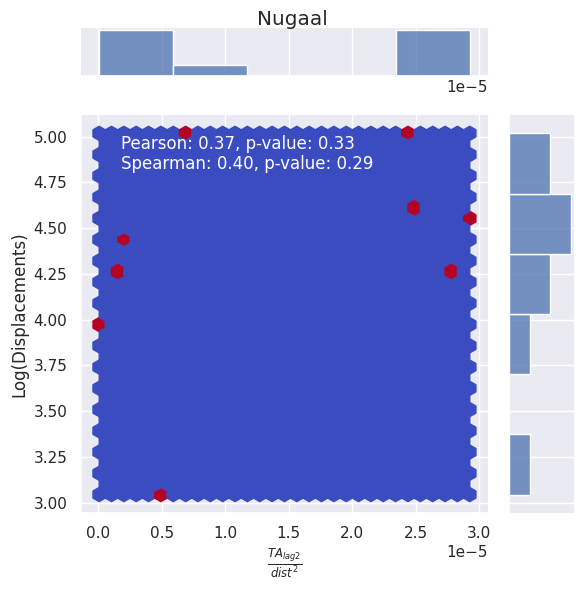

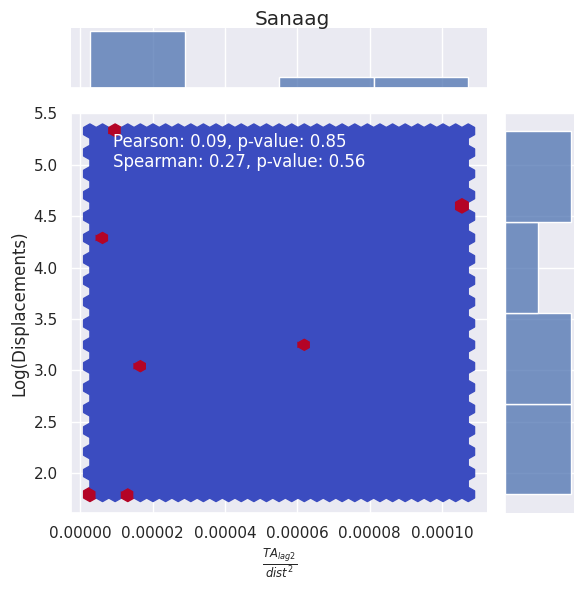

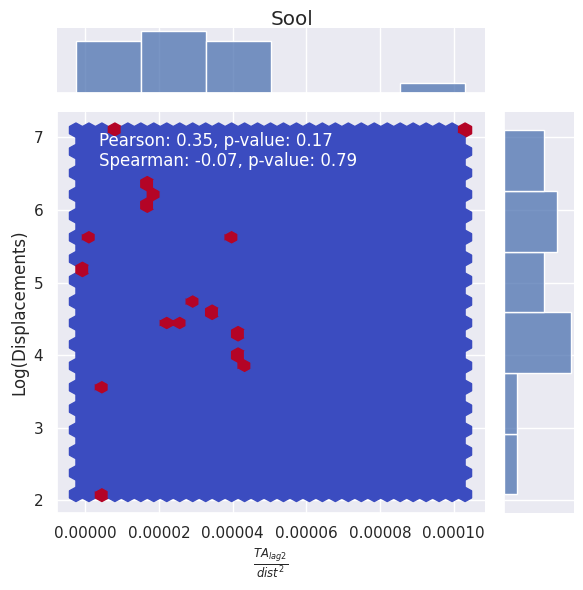

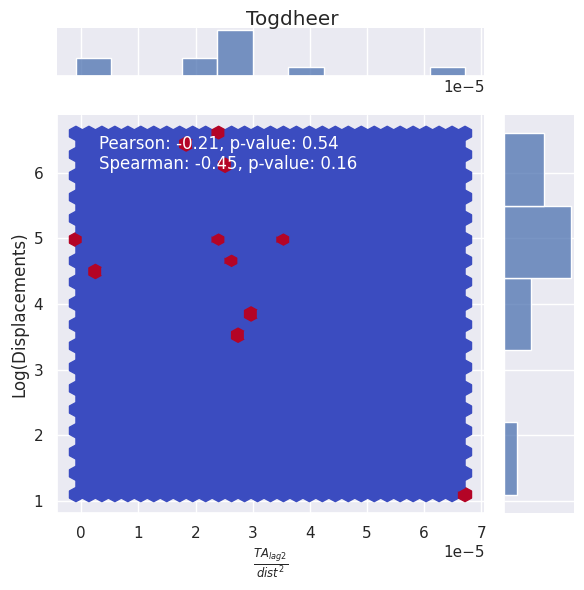

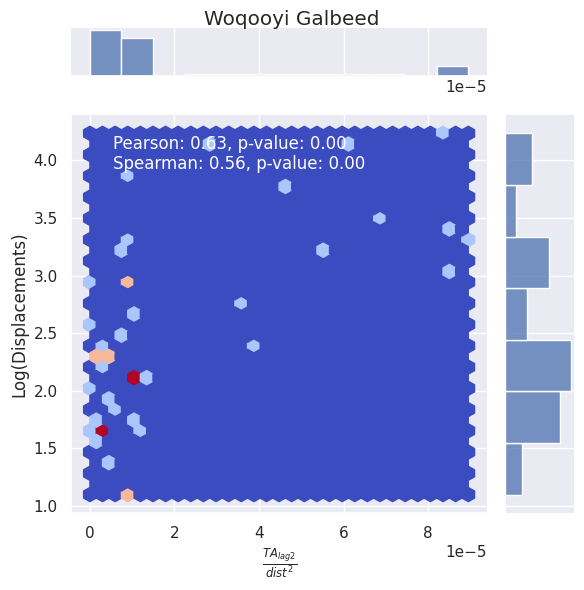

In [80]:
for i, j in enumerate(regions):
    row = i // 3  # Calculate the row index for the current region
    col = i % 3  # Calculate the column index for the current region
    vec_region = []
    df_j=[]

    #for year in range(2016, 2023):
        #disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
    for month in range(12):
        
        disp_reg = disp_matxs[j] #disp_matxs_i[j]
        disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
        disp_reg['inv_dist'] = inv_distance[j]
        df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
        disp_reg['TA_lag2'] = df_m_y['TA_lag2']
        disp_reg = disp_reg[disp_reg[j]!=0]
        
        vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['TA_lag2']*df_j['inv_dist']**2)]

    if len(df_j[j]) >= 2:
        corr_pearson, p_value_p = pearsonr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, p_value_s = spearmanr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j['TA_lag2']*df_j['inv_dist']**2
    #if df_j is empty:
        #continue
    if len(df_j[j])==0:
        continue

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[2]}}}{{dist^2}}$')
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}, p-value: {p_value_p:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}, p-value: {p_value_s:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')

plt.show()

## Heatmap Pearson and spearman coefficient

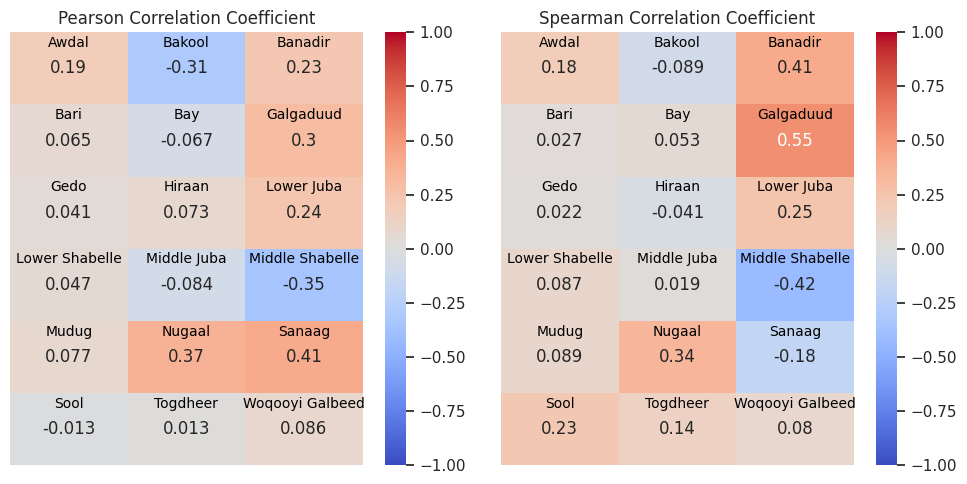

In [56]:
vec_corr_pearson = []
vec_corr_spearman = []

disp_matxs['year'] = disp_matxs.index.get_level_values('time').year

for j in regions:
    disp_reg_list = []
    
    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            color = cmap(region_codes[regions == j][0])
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
            disp_reg['TA_lag2'] = df_m_y['TA_lag2']
            disp_reg = disp_reg[disp_reg[j]!=0]

            disp_reg_list.append(disp_reg)

    df_j = pd.concat(disp_reg_list, ignore_index=True)
    df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag2'])]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j['TA_lag2']*df_j['inv_dist']**2, df_j[j])

        vec_corr_pearson.append(corr_pearson)
        vec_corr_spearman.append(corr_spearman)
    else:
        vec_corr_pearson.append(np.nan)
        vec_corr_spearman.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 3)
vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

sns.heatmap(vec_corr_pearson, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax1)
ax1.set_title('Pearson Correlation Coefficient')

sns.heatmap(vec_corr_spearman, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=ax2)
ax2.set_title('Spearman Correlation Coefficient')

for i, j in enumerate(regions):
    row = i // 3  # row index 
    col = i % 3   # column index 
    ax1.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)
    ax2.text(col + 0.5, row + 0.15, f"{j}", ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

## Heatmap Pearson and Spearman (lags and regions)

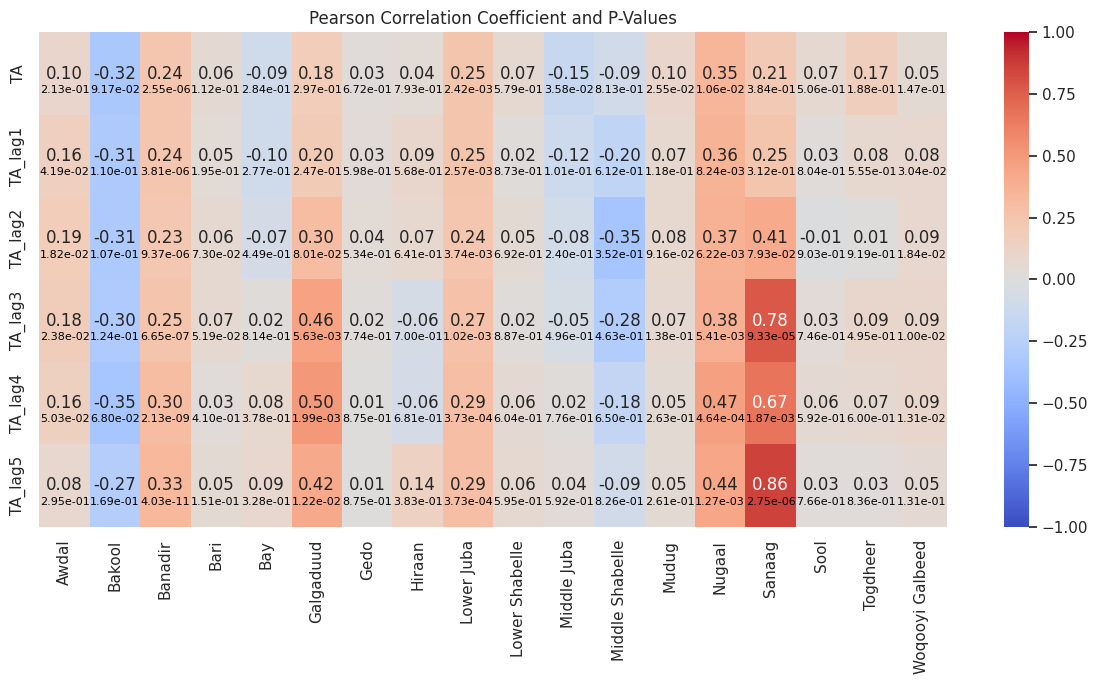

In [57]:
# Pearson coefficient heatmap

vec_corr_pearson = []
vec_p_values = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
                disp_reg['TA_lag_n'] = df_m_y[TA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_pearson, p_value = pearsonr(df_j['TA_lag_n']*df_j['inv_dist']**2, df_j[j])
            vec_corr_pearson.append(corr_pearson)
            vec_p_values.append(p_value)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)
vec_p_values = np.array(vec_p_values).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

# Add p-values to the heatmap
for i in range(vec_p_values.shape[0]):
    for j in range(vec_p_values.shape[1]):
        if not np.isnan(vec_p_values[i, j]):
            ax.text(j + 0.5, i + 0.7, f'{vec_p_values[i, j]:.2e}', ha='center', va='center', fontsize=8, color='black')

plt.title('Pearson Correlation Coefficient and P-Values')
plt.tight_layout()
plt.show()

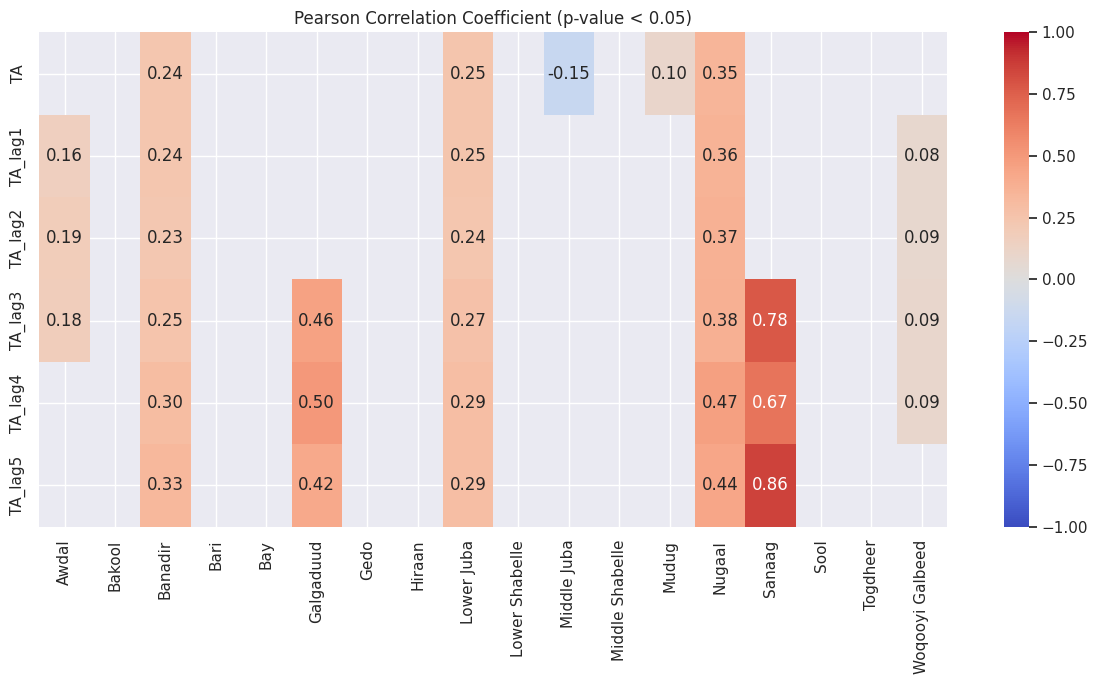

In [58]:
vec_corr_pearson = []
vec_p_values = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
                disp_reg['TA_lag_n'] = df_m_y[TA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_pearson, p_value = pearsonr(df_j['TA_lag_n']*df_j['inv_dist']**2, df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_pearson.append(corr_pearson)
            else:
                vec_corr_pearson.append(np.nan)
        else:
            vec_corr_pearson.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_pearson = np.array(vec_corr_pearson).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_pearson, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Pearson Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

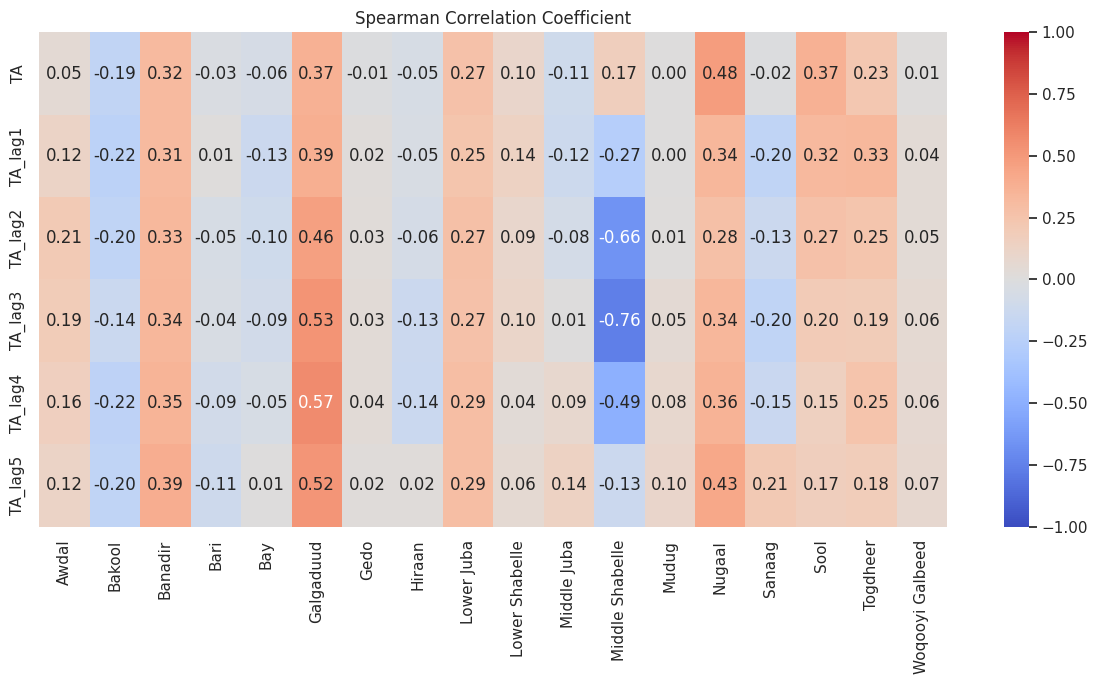

In [59]:
# Spearman coefficient heatmap

vec_corr_spearman = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(1, 13):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[18*(month-1):18*(month +17)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
                disp_reg['TA_lag_n'] = df_m_y[TA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['TA_lag_n']*df_j['inv_dist']**2)]

        if len(df_j[j]) >= 2:
            corr_spearman, _ = spearmanr(df_j['inv_dist']*df_j['TA_lag_n'], df_j[j])
            vec_corr_spearman.append(corr_spearman)
        else:
            vec_corr_spearman.append(np.nan)

vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 18)
#increase cell size
sns.set(rc={'figure.figsize':(12,7)})
sns.heatmap(vec_corr_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)
plt.title('Spearman Correlation Coefficient')
plt.tight_layout()
plt.show()

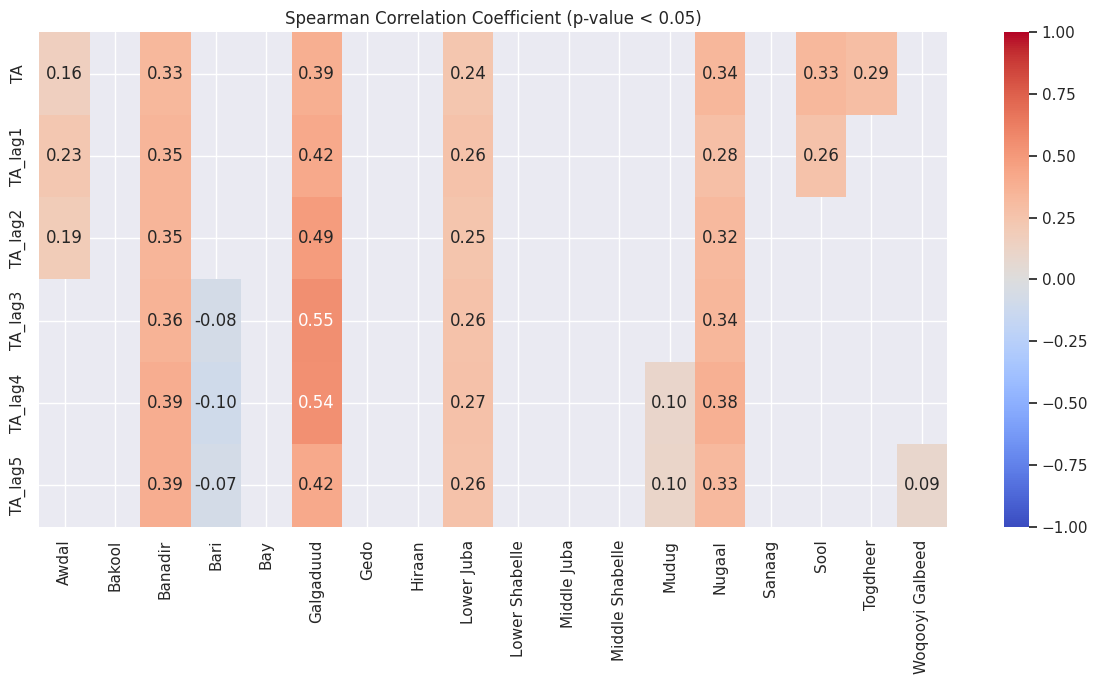

In [60]:
vec_corr_spearman = []
vec_p_values = []
disp_matxs['year'] = disp_matxs.index.get_level_values('time').year
reg_vec = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']

for TA_lag in reg_vec:

    for j in regions:
        disp_reg_list = []
        
        for year in range(2016, 2023):
            disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
            
            for month in range(12):
                color = cmap(region_codes[regions == j][0])
                disp_reg = disp_matxs_i[j]
                disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
                disp_reg['inv_dist'] = inv_distance[j]
                df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
                disp_reg['TA_lag_n'] = df_m_y[TA_lag]
                disp_reg = disp_reg[disp_reg[j]!=0]

                disp_reg_list.append(disp_reg)

        df_j = pd.concat(disp_reg_list, ignore_index=True)
        df_j = df_j[np.isfinite(df_j['inv_dist']*df_j['TA_lag_n'])]

        if len(df_j[j]) >= 2:
            corr_spearman, p_value = spearmanr(df_j['inv_dist']*df_j['TA_lag_n'], df_j[j])
            vec_p_values.append(p_value)
            if p_value <= 0.05:
                vec_corr_spearman.append(corr_spearman)
            else:
                vec_corr_spearman.append(np.nan)
        else:
            vec_corr_spearman.append(np.nan)
            vec_p_values.append(np.nan)

vec_corr_spearman = np.array(vec_corr_spearman).reshape(6, 18)

sns.set(rc={'figure.figsize':(12,7)})
ax = sns.heatmap(vec_corr_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1, xticklabels=regions, yticklabels=reg_vec)

plt.title('Spearman Correlation Coefficient (p-value < 0.05)')
plt.tight_layout()
plt.show()

## Jointplot for Banadir region with different lags

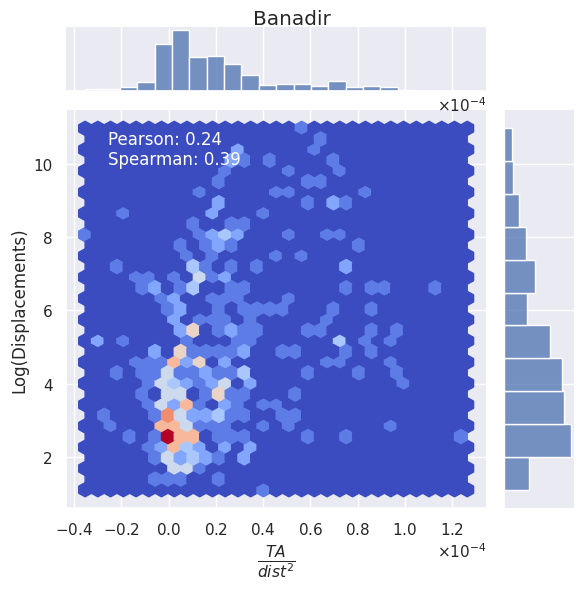

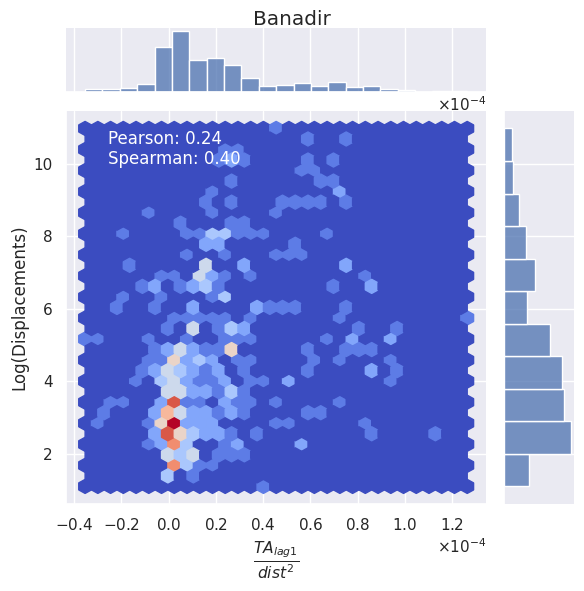

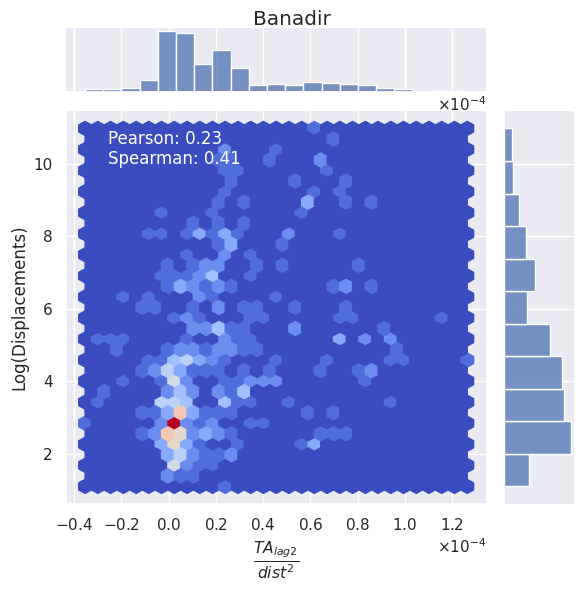

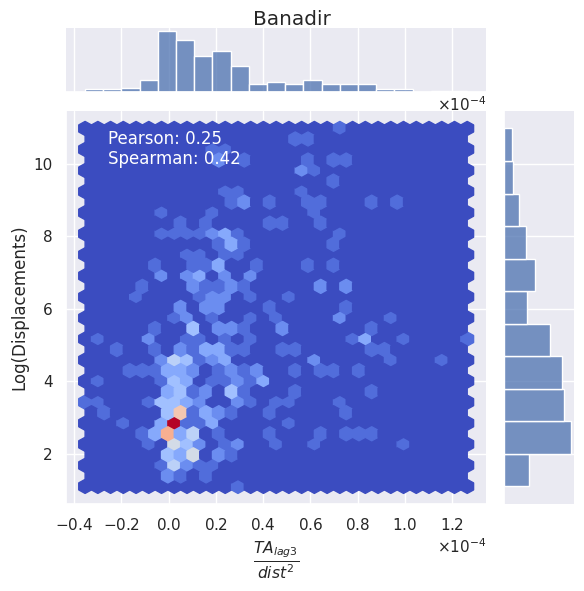

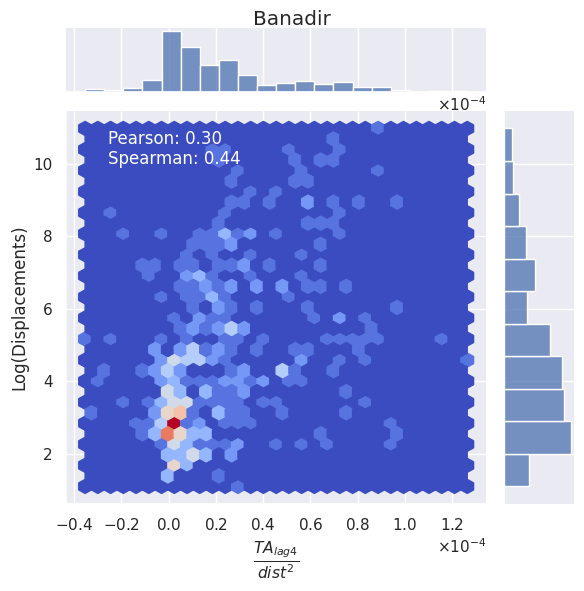

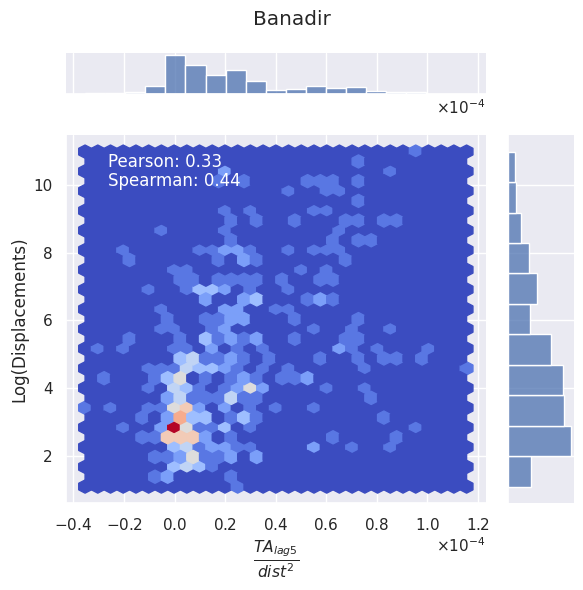

In [61]:
j = 'Banadir'
color = cmap(region_codes[regions == j][0])

for i, lag in enumerate(vac_lag):

    vec_region = []
    df_j=[]

    for year in range(2016, 2023):
        disp_matxs_i = disp_matxs[disp_matxs['year'] == year]
        
        for month in range(12):
            
            disp_reg = disp_matxs_i[j]
            disp_reg = disp_reg[(18*month):(18*month +18)].reset_index()
            disp_reg['inv_dist'] = inv_distance[j]
            df_m_y = df_d[(df_d['year'] == year) & (df_d['month'] == month+1)].reset_index()
            disp_reg[lag] = df_m_y[lag]
            disp_reg = disp_reg[disp_reg[j]!=0]
            
            vec_region.append(disp_reg)

    df_j = pd.concat(vec_region, ignore_index=True)
    df_j = df_j[np.isfinite(df_j[lag]*df_j['inv_dist']**2)]

    if len(df_j[j]) >= 2:
        corr_pearson, _ = pearsonr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
        corr_spearman, _ = spearmanr(df_j[lag]*df_j['inv_dist']**2, df_j[j])
    else:
        corr_pearson = np.nan
        corr_spearman = np.nan
    df_j[j] = np.log(df_j[j])
    df_j['x'] = df_j[lag]*df_j['inv_dist']**2

    g = sns.jointplot(data=df_j, x='x', y=j, kind='hex', cmap='coolwarm', joint_kws={'gridsize': 30})
    g.fig.set_size_inches(6, 6)
    g.ax_joint.set_xlabel(fr'$\frac{{{lag_str[i]}}}{{dist^2}}$', fontsize=16)
    g.ax_joint.set_ylabel('Log(Displacements)')
    g.fig.suptitle(j)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.ax_joint.text(0.1, 0.95, f"Pearson: {corr_pearson:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    g.ax_joint.text(0.1, 0.9, f"Spearman: {corr_spearman:.2f}", transform=g.ax_joint.transAxes, ha='left', va='top', color='white')
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    g.ax_joint.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


    #pearson
    #spearman

    #heatmp con regioni per righe e lag per colonne con il coeff di correlazione, per vedere se colonne sono piu significative
    #prova anche con PA e DL
    #diverse funz di distanza
    #per tutte le regioni distinte
    #e con tutte le regioni insieme
    #anzichè scatter heatmap dei punti (vedi seaborn, slack) 
    #(colora i punti proporzionalmente alla TA della regione di arrivo)
    #

## Correlation

In [26]:
arrival = disp_data.groupby(['time','Current (Arrival) Region'])['Number of Individuals'].sum()

In [28]:
disp_data.head()

time Previous (Departure) Region Current (Arrival) Region  \
0 2016-01-31                      Bakool                   Bakool   
1 2016-01-31                      Bakool                  Banadir   
2 2016-01-31                      Bakool                     Bari   
3 2016-01-31                      Bakool                      Bay   
4 2016-01-31                      Bakool                Galgaduud   

   Number of Individuals  
0                      0  
1                      0  
2                      0  
3                     14  
4                      0

In [33]:
sum_dep = disp_data.groupby('Previous (Departure) Region')['Number of Individuals'].sum()
sum_dep= sum_dep.to_frame()

In [27]:
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp")
states_gdf.head()

Shape_Leng  Shape_Area  ADM1_EN ADM1_PCODE  ADM0_EN ADM0_PCODE        date  \
0    5.657071    1.312224    Awdal       SO11  Somalia         SO  2022-12-21   
1    6.650225    2.101389   Bakool       SO25  Somalia         SO  2022-12-21   
2    1.068762    0.026612  Banadir       SO22  Somalia         SO  2022-12-21   
3   12.218762    5.618064     Bari       SO16  Somalia         SO  2022-12-21   
4    8.086913    3.572929      Bay       SO24  Somalia         SO  2022-12-21   

      validOn  validTo                                           geometry  
0  2023-03-08      NaN  MULTIPOLYGON (((43.46189 11.42429, 43.45532 11...  
1  2023-03-08      NaN  POLYGON ((44.03028 4.95968, 44.08498 4.95730, ...  
2  2023-03-08      NaN  POLYGON ((45.55389 2.15350, 45.55328 2.15308, ...  
3  2023-03-08      NaN  POLYGON ((50.79877 11.98356, 50.80576 11.97939...  
4  2023-03-08      NaN  POLYGON ((44.31110 3.57147, 44.31110 3.55957, ...

In [34]:
merged_shp_anx_mob = sum_dep.merge(states_gdf, left_on='Previous (Departure) Region', right_on='ADM1_EN')
merged_shp_anx_mob.head()

Number of Individuals  Shape_Leng  Shape_Area  ADM1_EN ADM1_PCODE  ADM0_EN  \
0                  53184    5.657071    1.312224    Awdal       SO11  Somalia   
1                 421067    6.650225    2.101389   Bakool       SO25  Somalia   
2                  54654    1.068762    0.026612  Banadir       SO22  Somalia   
3                 176573   12.218762    5.618064     Bari       SO16  Somalia   
4                 921943    8.086913    3.572929      Bay       SO24  Somalia   

  ADM0_PCODE        date     validOn  validTo  \
0         SO  2022-12-21  2023-03-08      NaN   
1         SO  2022-12-21  2023-03-08      NaN   
2         SO  2022-12-21  2023-03-08      NaN   
3         SO  2022-12-21  2023-03-08      NaN   
4         SO  2022-12-21  2023-03-08      NaN   

                                            geometry  
0  MULTIPOLYGON (((43.46189 11.42429, 43.45532 11...  
1  POLYGON ((44.03028 4.95968, 44.08498 4.95730, ...  
2  POLYGON ((45.55389 2.15350, 45.55328 2.15308, ...  
3  POLYGON ((50.79877 11.98356, 50.80576 11.97939...  
4  POLYGON ((44.31110 3.57147, 44.31110 3.55957, ...

In [ ]:
import matplotlib.patches as mpatches
# Merge the GeoDataFrame with the DataFrame containing state codes and numerical values
merged_shp_anx_mob = sum_dep.merge(states_gdf, left_on='Previous (Departure) Region', right_on='ADM1_EN')

cmap = 'coolwarm'

vmax=1; vmin=-1

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10,6))

ax1 = merged_shp_anx_mob.plot(
    column='corr',
    ax=ax[0],
    cmap=cmap,  # Use 'coolwarm' colormap for diverging colors from blue to red
    norm=plt.colors.Normalize(vmin=vmin, vmax=vmax),
    legend=None,
    legend_kwds={'label': "Mobility-Anxiety correlation", 'orientation': "vertical"},
)

ax[0].set_aspect(1.2)

ax2 = merged_shp_dep_mob.plot(
    column='corr',
    ax=ax[1],
    vmin=vmin, vmax=vmax,
    cmap=cmap,  # Use 'coolwarm' colormap for diverging colors from blue to red
    norm=plt.colors.Normalize(vmin=vmin, vmax=vmax),
    legend=None,
    legend_kwds={'label': "Mobility-Anxiety correlation", 'orientation': "vertical"},
)

# Legend
legend_patch = mpatches.Patch(color='#BBCBAC', label='p-val > 0.05')
ax[1].legend(handles=[legend_patch], loc='lower right', bbox_to_anchor=(1.1, 0.1))

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

fig.subplots_adjust(right=0.8)

ax[0].set_xlim(-130, -65)
ax[0].set_ylim(23, 50)

ax[1].set_xlim(-130, -65)
ax[1].set_ylim(23, 50)

ax[0].set_title('Feelings of Anxiety')
ax[1].set_title('Feelings of Depression')

ax[0].axis('off')
ax[1].axis('off')


cbar_axim = fig.add_axes([0.75, 0.27, 0.02, 0.5])
cbar = plt.colorbar(sm, shrink=0.5, cax=cbar_axim)
cbar.set_label('Spearman Correlation Coef.')

#plt.suptitle('Correlation with Mobility\n04/06 to 08/31', size=15,y=1, x=0.57)

plt.tight_layout() 

plt.savefig('mobility_mental_health_map.png')
plt.show()